In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

# Models we will use
from sklearn.base import clone

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

from xgboost import XGBClassifier

# to get estimates of the model results
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import time



ModuleNotFoundError: No module named 'matplotlib'

## Upload the data

In [2]:
df = pd.read_csv('../output/matches_with_players.csv')
df = df.drop(columns=['Players Found %','Match Link','Game ID'])
df

id   Wk  Day        Date   Time            Home  xG Home  G Home  \
0        1  1.0  Fri  2019-08-09  20:00       Liverpool      1.8       4   
1        2  1.0  Sat  2019-08-10  12:30        West Ham      1.1       0   
2        3  1.0  Sat  2019-08-10  15:00         Burnley      0.9       3   
3        4  1.0  Sat  2019-08-10  15:00         Watford      0.7       0   
4        5  1.0  Sat  2019-08-10  15:00  Crystal Palace      0.9       0   
...    ...  ...  ...         ...    ...             ...      ...     ...   
6817  6818  8.0  Sun  2022-09-18  20:45            Lyon      1.0       0   
6818  6819  9.0  Fri  2022-09-30  21:00          Angers      1.2       0   
6819  6820  9.0  Sat  2022-10-01  17:00      Strasbourg      1.3       1   
6820  6821  9.0  Sat  2022-10-01  21:00       Paris S-G      1.0       2   
6821  6822  9.0  Sun  2022-10-02  13:00         Lorient      0.6       2   

                 Away  xG Away  ...  Home Head-to-Head Points  \
0        Norwich City      0.9  ...                      0.00   
1     Manchester City      3.2  ...                      0.00   
2         Southampton      1.2  ...                      0.00   
3            Brighton      0.8  ...                      0.00   
4             Everton      1.1  ...                      0.00   
...               ...      ...  ...                       ...   
6817        Paris S-G      1.6  ...                      0.80   
6818        Marseille      1.6  ...                      1.00   
6819           Rennes      3.2  ...                      0.80   
6820             Nice      0.5  ...                      2.00   
6821            Lille      2.2  ...                      0.75   

     Away Head-to-Head Points Home Head-to-Head Goals For  \
0                        0.00                         0.0   
1                        0.00                         0.0   
2                        0.00                         0.0   
3                        0.00                         0.0   
4                        0.00                         0.0   
...                       ...                         ...   
6817                     2.00                         1.4   
6818                     1.60                         1.2   
6819                     2.00                         0.6   
6820                     0.80                         1.8   
6821                     2.25                         1.0   

      Away Head-to-Head Goals For  Home Head-to-Head Goals Against  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   
...                           ...                              ...   
6817                          2.2                              2.2   
6818                          1.8                              1.8   
6819                          1.2                              1.2   
6820                          0.6                              0.6   
6821                          3.0                              3.0   

      Away Head-to-Head Goals Against  Home Avg Players Score  \
0                                 0.0                   87.77   
1                                 0.0                   77.29   
2                                 0.0                   75.69   
3                                 0.0                   74.85   
4                                 0.0                   76.31   
...                               ...                     ...   
6817                              1.4                   76.80   
6818                              1.2                   71.19   
6819                              0.6                   72.75   
6820                              1.8                   86.83   
6821                     

Adding season column

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

# Function to determine the season
def get_season(date):
    year = date.year
    month = date.month
    if month >= 8:  # From August onwards, it is the new season
        return year
    else:
        return year - 1
df['Season'] = df['Date'].apply(get_season)
df

id   Wk  Day       Date   Time            Home  xG Home  G Home  \
0        1  1.0  Fri 2019-08-09  20:00       Liverpool      1.8       4   
1        2  1.0  Sat 2019-08-10  12:30        West Ham      1.1       0   
2        3  1.0  Sat 2019-08-10  15:00         Burnley      0.9       3   
3        4  1.0  Sat 2019-08-10  15:00         Watford      0.7       0   
4        5  1.0  Sat 2019-08-10  15:00  Crystal Palace      0.9       0   
...    ...  ...  ...        ...    ...             ...      ...     ...   
6817  6818  8.0  Sun 2022-09-18  20:45            Lyon      1.0       0   
6818  6819  9.0  Fri 2022-09-30  21:00          Angers      1.2       0   
6819  6820  9.0  Sat 2022-10-01  17:00      Strasbourg      1.3       1   
6820  6821  9.0  Sat 2022-10-01  21:00       Paris S-G      1.0       2   
6821  6822  9.0  Sun 2022-10-02  13:00         Lorient      0.6       2   

                 Away  xG Away  ...  Home Head-to-Head Points  \
0        Norwich City      0.9  ...                      0.00   
1     Manchester City      3.2  ...                      0.00   
2         Southampton      1.2  ...                      0.00   
3            Brighton      0.8  ...                      0.00   
4             Everton      1.1  ...                      0.00   
...               ...      ...  ...                       ...   
6817        Paris S-G      1.6  ...                      0.80   
6818        Marseille      1.6  ...                      1.00   
6819           Rennes      3.2  ...                      0.80   
6820             Nice      0.5  ...                      2.00   
6821            Lille      2.2  ...                      0.75   

     Away Head-to-Head Points  Home Head-to-Head Goals For  \
0                        0.00                          0.0   
1                        0.00                          0.0   
2                        0.00                          0.0   
3                        0.00                          0.0   
4                        0.00                          0.0   
...                       ...                          ...   
6817                     2.00                          1.4   
6818                     1.60                          1.2   
6819                     2.00                          0.6   
6820                     0.80                          1.8   
6821                     2.25                          1.0   

      Away Head-to-Head Goals For  Home Head-to-Head Goals Against  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   
...                           ...                              ...   
6817                          2.2                              2.2   
6818                          1.8                              1.8   
6819                          1.2                              1.2   
6820                          0.6                              0.6   
6821                          3.0                              3.0   

      Away Head-to-Head Goals Against  Home Avg Players Score  \
0                                 0.0                   87.77   
1                                 0.0                   77.29   
2                                 0.0                   75.69   
3                                 0.0                   74.85   
4                                 0.0                   76.31   
...                               ...                     ...   
6817                              1.4                   76.80   
6818                              1.2                   71.19   
6819                              0.6                   72.75   
6820                              1.8                   86.83   
6821                     

In [4]:
df.columns

Index(['id', 'Wk', 'Day', 'Date', 'Time', 'Home', 'xG Home', 'G Home', 'Away',
       'xG Away', 'G Away', 'League', 'Season', 'Score', 'Home Points',
       'Away Points', 'xScore', 'Home Avg Points', 'Away Avg Points',
       'Home Avg Goals For', 'Away Avg Goals For', 'Home Avg Goals Against',
       'Away Avg Goals Against', 'Home Matches Played', 'Away Matches Played',
       'Home Points/Match', 'Away Points/Match', 'Home Form Points',
       'Away Form Points', 'Home Form Goals For', 'Away Form Goals For',
       'Home Form Goals Against', 'Away Form Goals Against',
       'Home Head-to-Head Points', 'Away Head-to-Head Points',
       'Home Head-to-Head Goals For', 'Away Head-to-Head Goals For',
       'Home Head-to-Head Goals Against', 'Away Head-to-Head Goals Against',
       'Home Avg Players Score', 'Away Avg Players Score',
       'Home Star Player Count', 'Away Star Player Count'],
      dtype='object')

In [5]:
df.value_counts(['League'])

League        
La-Liga           1900
Premier-League    1900
Serie-A           1899
Ligue-1           1123
dtype: int64

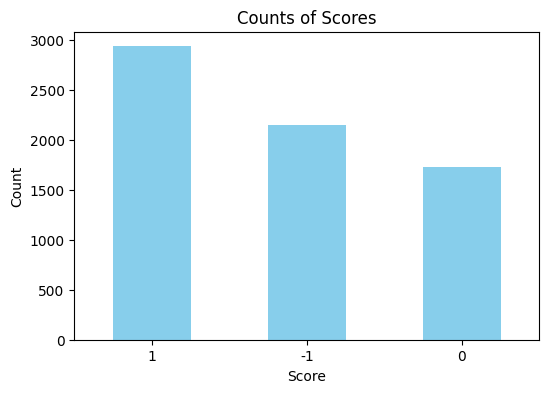

In [6]:
plt.figure(figsize=(6, 4))

value_counts = df['Score'].value_counts()
value_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


 ### Total number of goals scored in Home&Away matches

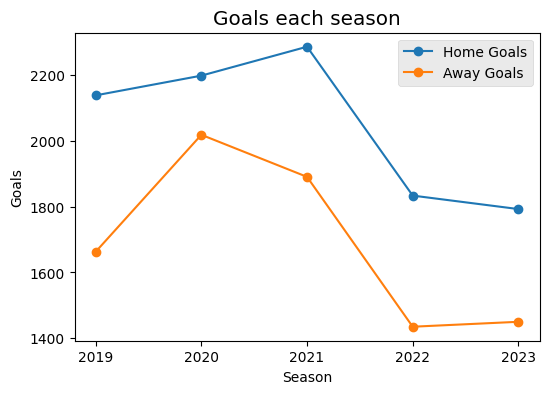

In [7]:
home_goals_per_season = df.groupby('Season')['G Home'].sum()
away_goals_per_season = df.groupby('Season')['G Away'].sum()

# Define the range of seasons
seasons = list(range(home_goals_per_season.index.min(), home_goals_per_season.index.max() + 1))

# Plotting home and away goals per season on the same plot
fig, ax = plt.subplots(figsize=(6, 4))
plt.style.use('ggplot')

ax.plot(home_goals_per_season.index, home_goals_per_season.values, label="Home Goals", marker='o')
ax.plot(away_goals_per_season.index, away_goals_per_season.values, label="Away Goals", marker='o')

ax.set_xticks(seasons)  # Setting x-ticks to be the seasons
ax.set_title('Goals each season')
ax.set_xlabel('Season')
ax.set_ylabel('Goals')
ax.legend()

plt.show()

### Top Goal Scoring Team at Home 


In [8]:
#Merging Home team and matches
matches_h_teams = df[['Home','G Home']]
matches_h_teams.head()

Home  G Home
0       Liverpool       4
1        West Ham       0
2         Burnley       3
3         Watford       0
4  Crystal Palace       0

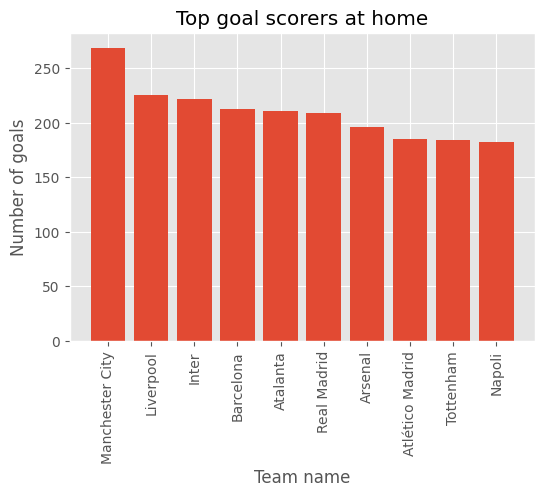

In [9]:
top_goal_scorers_home = matches_h_teams.groupby('Home')['G Home'].sum().sort_values(ascending=False)
%matplotlib inline 
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(10), top_goal_scorers_home.head(10).values,align = "center")
ax.set_xticks(range(10))
ax.set_xticklabels(top_goal_scorers_home.head(10).index,rotation = "vertical")
ax.set_title("Top goal scorers at home")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")
plt.show()

### Top Goal Scoring Team at Away 


In [10]:
#Merging Home team and matches
matches_a_teams = df[['Away','G Away']]
matches_a_teams.head()

Away  G Away
0     Norwich City       1
1  Manchester City       5
2      Southampton       0
3         Brighton       3
4          Everton       0

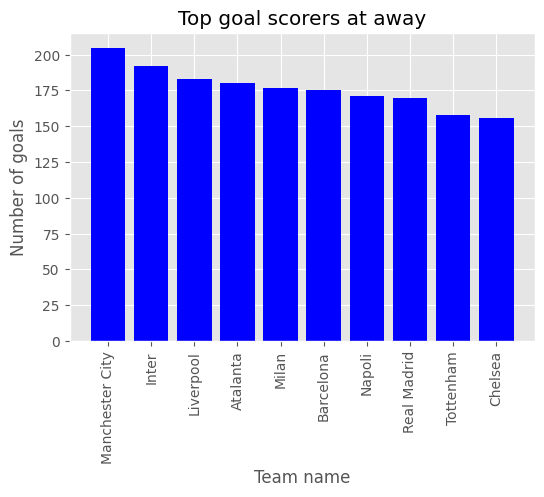

In [11]:
top_goal_scorers_away = matches_a_teams.groupby('Away')['G Away'].sum().sort_values(ascending=False)
%matplotlib inline 
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(10), top_goal_scorers_away.head(10).values,align = "center", color= 'blue')
ax.set_xticks(range(10))
ax.set_xticklabels(top_goal_scorers_away.head(10).index,rotation = "vertical")
ax.set_title("Top goal scorers at away")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")
plt.show()

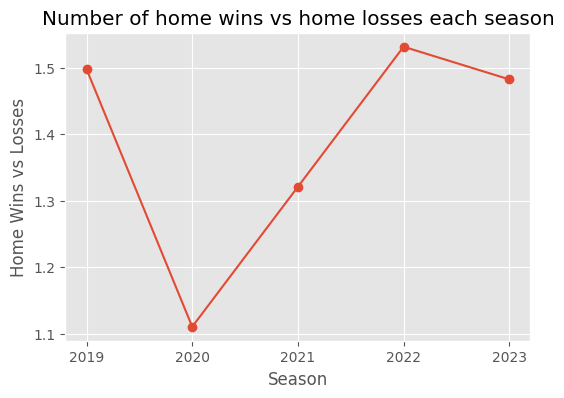

In [12]:
home_wins = df[(df.Score == 1)].groupby('Season').Score.sum()
home_losses = df[(df.Score == -1)].groupby('Season').Score.sum()

# Ensure both Series have the same index
home_wins, home_losses = home_wins.align(home_losses, join='inner')

# Calculating the ratio of home wins to home losses
e_hw = np.true_divide(home_wins.values, home_losses.values * -1)

# Plotting number of home wins vs home losses each season
fig = plt.figure(figsize=(6, 4))
plt.xticks(seasons)
plt.style.use('ggplot')
plt.title("Number of home wins vs home losses each season")
plt.xlabel("Season")
plt.ylabel("Home Wins vs Losses")
plt.plot(seasons, e_hw, marker='o')
plt.show()

### Encoding the data


In [13]:
encoded_df = df.copy()
label_encoders = {} # save the label encondeing
for column in encoded_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    if 'Home' in label_encoders and 'Away' == column:
        le =label_encoders['Home']

    encoded_df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# A sample of the encoded data frame
encoded_df


id   Wk  Day       Date  Time  Home  xG Home  G Home  Away  xG Away  \
0        1  1.0    0 2019-08-09    32    56      1.8       4    73      0.9   
1        2  1.0    2 2019-08-10     1   106      1.1       0    61      3.2   
2        3  1.0    2 2019-08-10    10    21      0.9       3    92      1.2   
3        4  1.0    2 2019-08-10    10   104      0.7       0    20      0.8   
4        5  1.0    2 2019-08-10    10    28      0.9       0    35      1.1   
...    ...  ...  ...        ...   ...   ...      ...     ...   ...      ...   
6817  6818  8.0    3 2022-09-18    35    59      1.0       0    77      1.6   
6818  6819  9.0    0 2022-09-30    37     4      1.2       0    63      1.6   
6819  6820  9.0    2 2022-10-01    18    94      1.3       1    83      3.2   
6820  6821  9.0    2 2022-10-01    37    77      1.0       2    72      0.5   
6821  6822  9.0    3 2022-10-02     4    57      0.6       2    55      2.2   

      ...  Home Head-to-Head Points  Away Head-to-Head Points  \
0     ...                      0.00                      0.00   
1     ...                      0.00                      0.00   
2     ...                      0.00                      0.00   
3     ...                      0.00                      0.00   
4     ...                      0.00                      0.00   
...   ...                       ...                       ...   
6817  ...                      0.80                      2.00   
6818  ...                      1.00                      1.60   
6819  ...                      0.80                      2.00   
6820  ...                      2.00                      0.80   
6821  ...                      0.75                      2.25   

      Home Head-to-Head Goals For  Away Head-to-Head Goals For  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          0.0   
3                             0.0                          0.0   
4                             0.0                          0.0   
...                           ...                          ...   
6817                          1.4                          2.2   
6818                          1.2                          1.8   
6819                          0.6                          1.2   
6820                          1.8                          0.6   
6821                          1.0                          3.0   

      Home Head-to-Head Goals Against  Away Head-to-Head Goals Against  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   
...                               ...                              ...   
6817                              2.2                              1.4   
6818                              1.8                              1.2   
6819                              1.2                              0.6   
6820                              0.6                              1.8   
6821                              3.0                              1.0   

      Home Avg Players Score  Away Avg Players Score  Home Star Player Count  \
0                      87.77                   73.07                       9   
1                      77.29                   87.52                       0   
2                      75.69                   75.50                       0   
3                      74.85                   79.50                       0   
4                      76.31                   81.11                       0   
...                      ...                     ...                     ...   
6817                   76.80        

### Correlation matrix

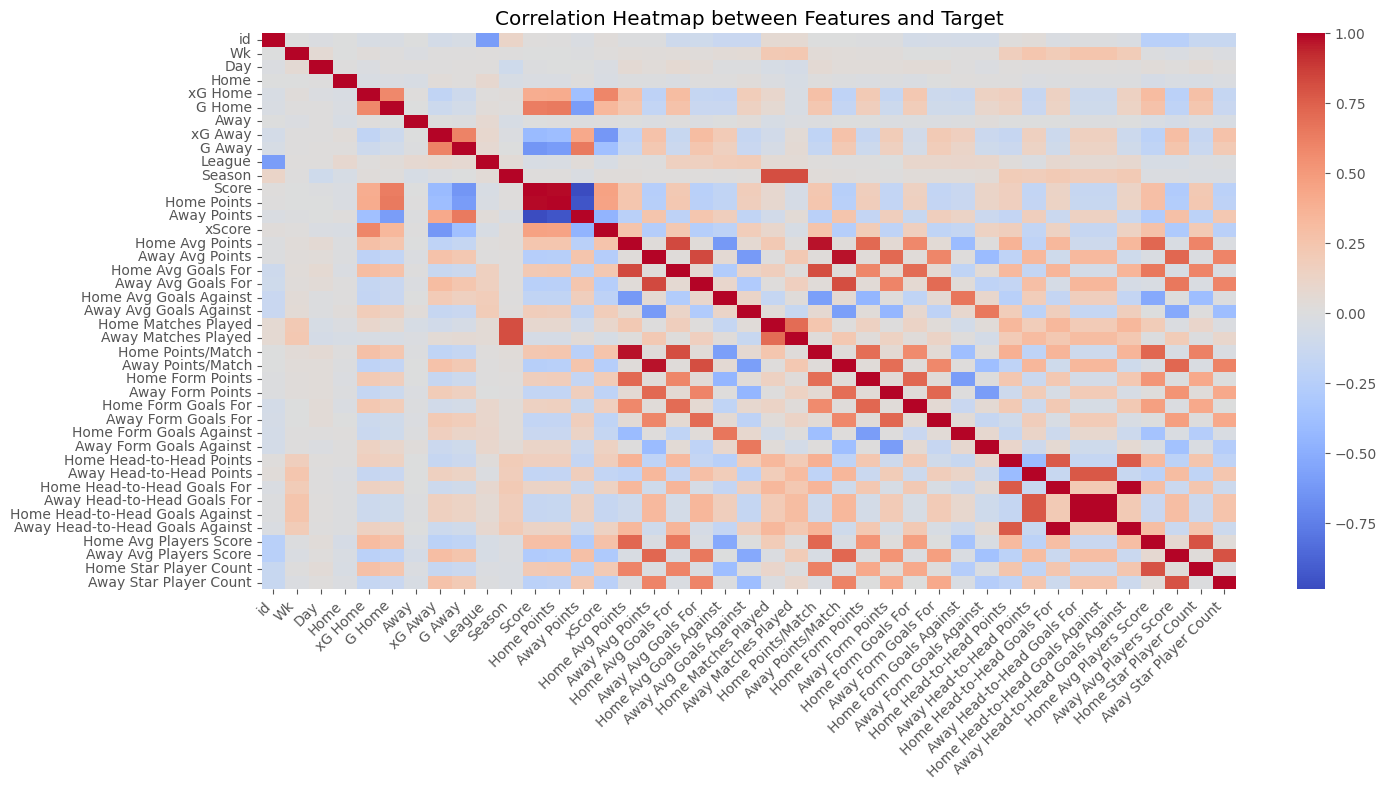

In [14]:
selected_features_with_target = encoded_df.drop(['Date','Time'],axis=1)

# Calculate the correlation matrix
correlation_matrix = selected_features_with_target.corr()

# Create a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 8})
plt.title('Correlation Heatmap between Features and Target')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Rotate y-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

## Normoalize the data
The score of the players need to be normalized

In [167]:
scaler = MinMaxScaler()

# Select the columns to normalize
columns_to_normalize = ['xG Home', 'G Home', 'xG Away', 'G Away', 'Home Avg Players Score',
                      'Away Avg Players Score', 'Home Points', 'Away Points', 'xScore',
                      'Home Avg Points', 'Away Avg Points', 'Home Avg Goals For',
                      'Away Avg Goals For', 'Home Avg Goals Against',
                      'Away Avg Goals Against', 'Home Matches Played', 'Away Matches Played',
                      'Home Points/Match', 'Away Points/Match', 'Home Form Points',
                      'Away Form Points', 'Home Form Goals For', 'Away Form Goals For',
                      'Home Form Goals Against', 'Away Form Goals Against',
                      'Home Head-to-Head Points', 'Away Head-to-Head Points',
                      'Home Head-to-Head Goals For', 'Away Head-to-Head Goals For',
                      'Home Head-to-Head Goals Against', 'Away Head-to-Head Goals Against']

# Fit and transform the selected columns
encoded_df[columns_to_normalize] = scaler.fit_transform(encoded_df[columns_to_normalize])
encoded_df

id   Wk  Day       Date  Time  Home   xG Home    G Home  Away  \
0        1  1.0    0 2019-08-09    32    56  0.257143  0.444444    73   
1        2  1.0    2 2019-08-10     1   106  0.157143  0.000000    61   
2        3  1.0    2 2019-08-10    10    21  0.128571  0.333333    92   
3        4  1.0    2 2019-08-10    10   104  0.100000  0.000000    20   
4        5  1.0    2 2019-08-10    10    28  0.128571  0.000000    35   
...    ...  ...  ...        ...   ...   ...       ...       ...   ...   
6817  6818  8.0    3 2022-09-18    35    59  0.142857  0.000000    77   
6818  6819  9.0    0 2022-09-30    37     4  0.171429  0.000000    63   
6819  6820  9.0    2 2022-10-01    18    94  0.185714  0.111111    83   
6820  6821  9.0    2 2022-10-01    37    77  0.142857  0.222222    72   
6821  6822  9.0    3 2022-10-02     4    57  0.085714  0.222222    55   

       xG Away  ...  Home Head-to-Head Points  Away Head-to-Head Points  \
0     0.183673  ...                  0.000000                  0.000000   
1     0.653061  ...                  0.000000                  0.000000   
2     0.244898  ...                  0.000000                  0.000000   
3     0.163265  ...                  0.000000                  0.000000   
4     0.224490  ...                  0.000000                  0.000000   
...        ...  ...                       ...                       ...   
6817  0.326531  ...                  0.266667                  0.666667   
6818  0.326531  ...                  0.333333                  0.533333   
6819  0.653061  ...                  0.266667                  0.666667   
6820  0.102041  ...                  0.666667                  0.266667   
6821  0.448980  ...                  0.250000                  0.750000   

      Home Head-to-Head Goals For  Away Head-to-Head Goals For  \
0                        0.000000                        0.000   
1                        0.000000                        0.000   
2                        0.000000                        0.000   
3                        0.000000                        0.000   
4                        0.000000                        0.000   
...                           ...                          ...   
6817                     0.155556                        0.275   
6818                     0.133333                        0.225   
6819                     0.066667                        0.150   
6820                     0.200000                        0.075   
6821                     0.111111                        0.375   

      Home Head-to-Head Goals Against  Away Head-to-Head Goals Against  \
0                               0.000                         0.000000   
1                               0.000                         0.000000   
2                               0.000                         0.000000   
3                               0.000                         0.000000   
4                               0.000                         0.000000   
...                               ...                              ...   
6817                            0.275                         0.155556   
6818                            0.225                         0.133333   
6819                            0.150                         0.066667   
6820                            0.075                         0.200000   
6821                            0.375                         0.111111   

      Home Avg Players Score  Away Avg Players Score  Home Star Player Count  \
0                   0.955526                0.287351                       9   
1                   0.484726                0.949588                       0   
2                   0.412848                0.398717                       0   
3                   0.375112                0.582035                       0   
4                   0.440701                0.655820                       0   
...                      ...                     ...                

## Split to train test and validation
we will use one season for the validation and one for the test and the rest for the train

In [169]:
target =  df['Score']
#you might want to drop also 'Away Matches Played','Home Matches Played' for decrease repeatingencoded_features = encoded_df.drop(['Game ID', 'Wk', 'Day', 'Date','Time','Score','G Home','Home Points', 'Away Points','G Away'], axis =1)
encoded_features = encoded_df.drop(['Date','Time','Score','G Home','Home Points', 'Away Points','G Away','League','id'], axis =1)
first_year = 2019
encoded_features['Season'] -= first_year

X_train, X_test, y_train, y_test = train_test_split(encoded_features, target, test_size=0.2, random_state=42)
X_test, X_val,  y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# X_train = encoded_features[:train_size]
# X_test = encoded_features[train_size:train_size+test_size]
# X_val= encoded_features[train_size+test_size:train_size+test_size+val_size]

# y_train = df['Score'][0:train_size]
# y_test =   df['Score'][train_size:train_size+test_size]
# y_val =  df['Score'][train_size+test_size:train_size+test_size+val_size]
# y_train = df[df['Season'] <= last_year-3]['Score']
# y_val =  df[df['Season'] == last_year-2]['Score']
# y_test = df[df['Season'] ==  last_year-1]['Score']


print("Number of training set: ", len(X_train))
print("Number of validation set: ", len(X_val))
print("Number of test set: ", len(X_test))
print("Total number of dataset: ", len(X_train)+len(X_test)+len(X_val))

Number of training set:  5457
Number of validation set:  683
Number of test set:  682
Total number of dataset:  6822


### Balance the data
For each algorithem we will apply the regular dataset and also the balance dataset

In [170]:
class_weights_resampled = {
    0: (y_train == 0).sum(),  # Weight for draws
    1: (y_train == 1).sum(),  # Weight for wins
    -1: (y_train == -1).sum()   # Weight for losses
}
class_weights_resampled

{0: 1371, 1: 2345, -1: 1741}

In [171]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)  # Resample to balance class distribution
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

class_weights_resampled = {
    0: (y_resampled == 0).sum(),  # Weight for draws
    1: (y_resampled == 1).sum(),  # Weight for wins
    -1: (y_resampled == -1).sum()   # Weight for losses
}
class_weights_resampled

{0: 2345, 1: 2345, -1: 2345}

## Feature Selection

We will select features using a combination of correlation analysis, feature types, and feature selection algorithms.

First, we will define a feature selection class that integrates these methods.
For each FS we will have four varible that affect from the selection:

* newX_train - X train with selected features 
* newX_resampled - X resampled with selected features
* newX_test - X test with selected features
* newX_val -  X val with selected features

In [172]:
class FeatureSelection():
    def __init__ (self,name, newX_train,newX_resampled, newX_test, newX_val):
        self.name = name
        self.newX_train = newX_train
        self.newX_resampled = newX_resampled
        self.newX_test = newX_test
        self.newX_val = newX_val
        
        # Define the classifers
        self.LR = None
        self.LRResample = None

        self.DT = None
        self.DTResample = None
        self.RF = None
        self.RFResample = None

        self.KNN = None
        self.KNNResample = None
        self.SVM = None
        self.SVMResample = None
        self.XGB  = None
        self.XGBResample  = None


    def getSelectedFeatuersNames(self):
        return self.newX_train.columns

    def getSelectedFeatureIindices(self):
        return  [X_train.columns.get_loc(feature) for feature in self.getSelectedFeatuersNames()]

    def getalgorithms(self):
        return [self.LR,self.DT,self.RF,self.AdaBoost,self.KNN,self.SVM, self.Voting]

    def correlationSelectedFeatures(self):
        selected_features_with_target = pd.concat([self.newX_train, y_train], axis=1)

        # Calculate the correlation matrix
        correlation_matrix = selected_features_with_target.corr()

        # Create a heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlation Heatmap between Selected Features with {self.name} and Target')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

        plt.show()

First let's create an instance of the class, without feature selection

In [173]:
withoutFS = FeatureSelection("Without FS", X_train,X_resampled, X_test, X_val)


### Correlation matrix
We will use the correlation matrix to select relevant features for predicting game outcomes. 

Specifically, we will focus on features that have a strong correlation with the following key variables: 'Score', 'G Home', 'Home Points', 'Away Points', and 'G Away'. These features are expected to provide valuable insights into predicting the outcome of a game.

In [174]:
key_features = ['Score', 'G Home', 'Home Points', 'Away Points', 'G Away']

# Compute the correlation matrix
correlation_matrix = encoded_df.corr()

# Select features that have a correlation greater than a specified threshold with any of the key features
threshold = 0.2  # You can adjust this threshold as needed
selected_features = set()

for feature in key_features:
    if feature in correlation_matrix.columns:
        relevant_features = correlation_matrix[feature].abs() > threshold
        selected_features.update(relevant_features[relevant_features].index)
        
# Exclude the key features themselves from the list of selected features
selected_features.difference_update(set(key_features))

# Print the selected features
print("Selected features:", selected_features)

Selected features: {'xScore', 'Away Points/Match', 'Home Star Player Count', 'Home Points/Match', 'Away Avg Players Score', 'xG Home', 'Away Star Player Count', 'Home Avg Goals For', 'Home Avg Players Score', 'xG Away', 'Away Avg Goals For', 'Home Avg Points', 'Away Avg Points'}


C:\Users\Gadi\AppData\Local\Temp\ipykernel_32340\2604089419.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = encoded_df.corr()


In [175]:
corrSelectX_train = X_train[list(selected_features)]
corrSelectX_resampled = X_resampled[list(selected_features)]

corrSelectX_test = X_test[list(selected_features)]
corrSelectX_val = X_val[list(selected_features)]

SelectCorr = FeatureSelection("correlation FS", corrSelectX_train,corrSelectX_resampled,corrSelectX_test,corrSelectX_val)

We choose the features with correlation matrix so let see the correlation between the features.

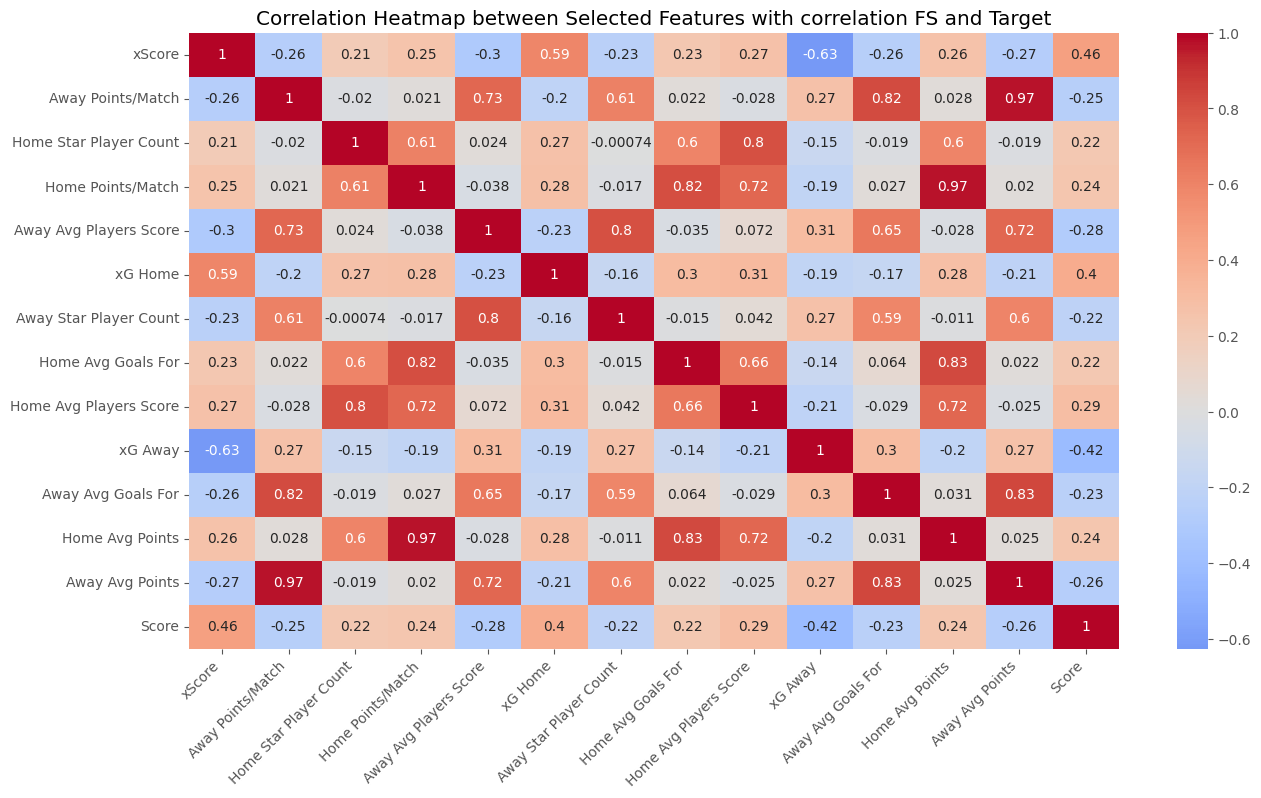

In [176]:
SelectCorr.correlationSelectedFeatures()

### RFE
We want to use algroithems that determinate which features are the most important we will use the RFE with Random Forest.

RFE is a method for feature selection that recursively removes the least important features and builds the model with the remaining features. The goal is to identify the subset of features that contributes most to the model’s performance.

How RFE Works:
1. Initial Model Training: RFE starts by training a model on all available features.
2. Feature Ranking: It evaluates the importance of each feature based on the model’s coefficients or feature importance scores.
3. Feature Elimination: The least important features (based on their importance scores) are removed.
4. Model Re-Training: The model is retrained on the remaining features.
5. Iteration: Steps 2 to 4 are repeated until the desired number of features is reached.
6. Evaluation: The final model is evaluated using cross-validation to ensure that the selected features lead to good performance.


The number of features that yields the best performance is chosen, and RFE is used to identify those features.

In [177]:
# Define the model
model = RandomForestClassifier(random_state= 42)

# Define the number of features to test
n_features_options = range(1, X_train.shape[1] + 1)
rfe_scores = []

for n_features in n_features_options:
    # Initialize RFE
    rfe = RFE(model, n_features_to_select=n_features)
    
    # Fit RFE
    rfe = rfe.fit(X_train, y_train)
    
    # Evaluate model with selected features using cross-validation
    selected_features =X_train.columns[rfe.support_]
    X_train_selected = X_train[selected_features]

    X_val_selected = X_val[selected_features]
    model.fit(X_train_selected, y_train)

    score = model.score(X_val_selected,y_val)  # test on val set
    rfe_scores.append(score)
    print(f'Validation score with {n_features} features: {score}')

# Determine the best number of features
best_n_features = n_features_options[np.argmax(rfe_scores)]
print(f"Best number of features: {best_n_features}")

# Fit the RFE with the best number of features
rfe = RFE(model, n_features_to_select=best_n_features)
rfe = rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_]
print("Selected features:", selected_features_rfe)


Validation score with 1 features: 0.43045387994143486
Validation score with 2 features: 0.43484626647144947
Validation score with 3 features: 0.47291361639824303
Validation score with 4 features: 0.5007320644216691
Validation score with 5 features: 0.5563689604685212
Validation score with 6 features: 0.5739385065885798
Validation score with 7 features: 0.5636896046852123
Validation score with 8 features: 0.5505124450951684
Validation score with 9 features: 0.5607613469985359
Validation score with 10 features: 0.5636896046852123
Validation score with 11 features: 0.541727672035139
Validation score with 12 features: 0.5519765739385066
Validation score with 13 features: 0.554904831625183
Validation score with 14 features: 0.5519765739385066
Validation score with 15 features: 0.5402635431918009
Validation score with 16 features: 0.5607613469985359
Validation score with 17 features: 0.5519765739385066
Validation score with 18 features: 0.554904831625183
Validation score with 19 features: 0.

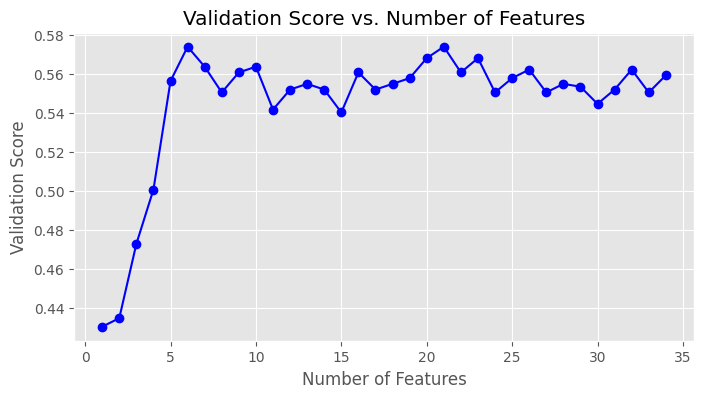

In [178]:
plt.figure(figsize=(8, 4))
plt.plot(n_features_options, rfe_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Features')
plt.ylabel('Validation Score')
plt.title('Validation Score vs. Number of Features')
plt.grid(True)
plt.show()

In [179]:
RFEX_train = X_train[list(selected_features_rfe)]
RFEX_resampled = X_resampled[list(selected_features_rfe)]
RFEX_test = X_test[list(selected_features_rfe)]
RFEX_val = X_val[list(selected_features_rfe)]

RFEFS = FeatureSelection('RFE FS', RFEX_train,RFEX_resampled,RFEX_test,RFEX_val)
RFEFS.getSelectedFeatuersNames()

Index(['xG Home', 'xG Away', 'Home Avg Points', 'Away Points/Match',
       'Home Avg Players Score', 'Away Avg Players Score'],
      dtype='object')

We also aim to perform feature selection based on the types of features we have. Specifically, we will focus on two main categories of features:

* Historical Statistics: This includes data from past games, such as previous wins and historical performance metrics.
* Current Metrics: This encompasses current statistics, such as player scores and xG data.

### Historical Statistic

In [180]:
HistoricalStatistics = ['Home Avg Points', 'Away Avg Points', 'Home Avg Goals For',
       'Away Avg Goals For', 'Home Avg Goals Against',
       'Away Avg Goals Against','Home Points/Match', 'Away Points/Match', 'Home Form Points',
       'Away Form Points', 'Home Form Goals For', 'Away Form Goals For',
       'Home Form Goals Against', 'Away Form Goals Against',
       'Home Head-to-Head Points', 'Away Head-to-Head Points',
       'Home Head-to-Head Goals For', 'Away Head-to-Head Goals For']

HistoricalX_train = X_train[HistoricalStatistics]
HistoricalX_resampled = X_resampled[HistoricalStatistics]

HistoricalX_test = X_test[HistoricalStatistics]
HistoricalX_val = X_val[HistoricalStatistics]

HistoricalFS = FeatureSelection('Historical', HistoricalX_train,HistoricalX_resampled,HistoricalX_test,HistoricalX_val)
print(HistoricalFS.getSelectedFeatuersNames())


Index(['Home Avg Points', 'Away Avg Points', 'Home Avg Goals For',
       'Away Avg Goals For', 'Home Avg Goals Against',
       'Away Avg Goals Against', 'Home Points/Match', 'Away Points/Match',
       'Home Form Points', 'Away Form Points', 'Home Form Goals For',
       'Away Form Goals For', 'Home Form Goals Against',
       'Away Form Goals Against', 'Home Head-to-Head Points',
       'Away Head-to-Head Points', 'Home Head-to-Head Goals For',
       'Away Head-to-Head Goals For'],
      dtype='object')


### Current Metrics

In [181]:
df.columns

Index(['id', 'Wk', 'Day', 'Date', 'Time', 'Home', 'xG Home', 'G Home', 'Away',
       'xG Away', 'G Away', 'League', 'Season', 'Score', 'Home Points',
       'Away Points', 'xScore', 'Home Avg Points', 'Away Avg Points',
       'Home Avg Goals For', 'Away Avg Goals For', 'Home Avg Goals Against',
       'Away Avg Goals Against', 'Home Matches Played', 'Away Matches Played',
       'Home Points/Match', 'Away Points/Match', 'Home Form Points',
       'Away Form Points', 'Home Form Goals For', 'Away Form Goals For',
       'Home Form Goals Against', 'Away Form Goals Against',
       'Home Head-to-Head Points', 'Away Head-to-Head Points',
       'Home Head-to-Head Goals For', 'Away Head-to-Head Goals For',
       'Home Head-to-Head Goals Against', 'Away Head-to-Head Goals Against',
       'Home Avg Players Score', 'Away Avg Players Score',
       'Home Star Player Count', 'Away Star Player Count'],
      dtype='object')

Index(['Away', 'xG Away', 'Home Avg Players Score', 'xScore',
       'Away Avg Players Score', 'Home Star Player Count',
       'Away Star Player Count'],
      dtype='object')


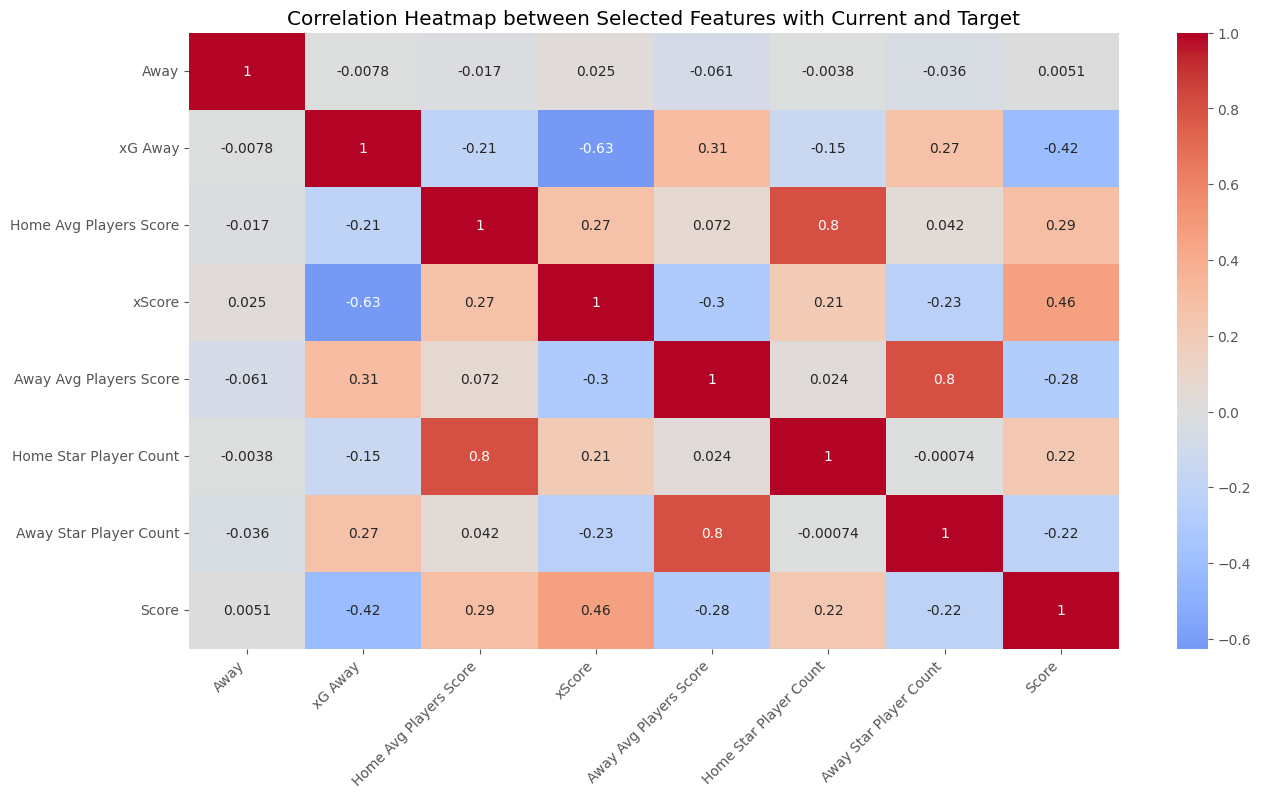

In [182]:
CurrentFeatures = ['Away', 'xG Away', 'Home Avg Players Score','xScore',
       'Away Avg Players Score','Home Star Player Count', 'Away Star Player Count']


CurrentX_train =X_train[CurrentFeatures]
CurrentX_resampled =X_resampled[CurrentFeatures]

CurrentX_test = X_test[CurrentFeatures]
CurrentX_val = X_val[CurrentFeatures]

CurrentFS = FeatureSelection('Current', CurrentX_train,CurrentX_resampled,CurrentX_test,CurrentX_val)
print(CurrentFS.getSelectedFeatuersNames())

CurrentFS.correlationSelectedFeatures()

### Manual Feature Selection

The final step in our feature selection process is manual selection. This involves reviewing the features and manually dropping those that we deem irrelevant based on our domain knowledge.

In [183]:
df.columns

Index(['id', 'Wk', 'Day', 'Date', 'Time', 'Home', 'xG Home', 'G Home', 'Away',
       'xG Away', 'G Away', 'League', 'Season', 'Score', 'Home Points',
       'Away Points', 'xScore', 'Home Avg Points', 'Away Avg Points',
       'Home Avg Goals For', 'Away Avg Goals For', 'Home Avg Goals Against',
       'Away Avg Goals Against', 'Home Matches Played', 'Away Matches Played',
       'Home Points/Match', 'Away Points/Match', 'Home Form Points',
       'Away Form Points', 'Home Form Goals For', 'Away Form Goals For',
       'Home Form Goals Against', 'Away Form Goals Against',
       'Home Head-to-Head Points', 'Away Head-to-Head Points',
       'Home Head-to-Head Goals For', 'Away Head-to-Head Goals For',
       'Home Head-to-Head Goals Against', 'Away Head-to-Head Goals Against',
       'Home Avg Players Score', 'Away Avg Players Score',
       'Home Star Player Count', 'Away Star Player Count'],
      dtype='object')

In [184]:
non_relavant_features = ['Wk', 'Day','Season','Home Matches Played', 'Away Matches Played','Home','Away',
                        'Home Head-to-Head Goals Against', 'Away Head-to-Head Goals Against']

XFeatures = X_train.columns
manual_features = XFeatures.drop(non_relavant_features)

ManualX_train = X_train[manual_features]
ManualX_resampled = X_resampled[manual_features]

ManualX_test = X_test[manual_features]
ManualX_val = X_val[manual_features]

ManualFS = FeatureSelection('Manual', ManualX_train,ManualX_resampled,ManualX_test,ManualX_val)
print(ManualFS.getSelectedFeatuersNames())

Index(['xG Home', 'xG Away', 'xScore', 'Home Avg Points', 'Away Avg Points',
       'Home Avg Goals For', 'Away Avg Goals For', 'Home Avg Goals Against',
       'Away Avg Goals Against', 'Home Points/Match', 'Away Points/Match',
       'Home Form Points', 'Away Form Points', 'Home Form Goals For',
       'Away Form Goals For', 'Home Form Goals Against',
       'Away Form Goals Against', 'Home Head-to-Head Points',
       'Away Head-to-Head Points', 'Home Head-to-Head Goals For',
       'Away Head-to-Head Goals For', 'Home Avg Players Score',
       'Away Avg Players Score', 'Home Star Player Count',
       'Away Star Player Count'],
      dtype='object')


In [185]:
 #allFS for all the Feature selection we have
allFS = [withoutFS,SelectCorr,RFEFS,HistoricalFS,CurrentFS,ManualFS]

In [186]:
CurrentFS.newX_resampled.columns

Index(['Away', 'xG Away', 'Home Avg Players Score', 'xScore',
       'Away Avg Players Score', 'Home Star Player Count',
       'Away Star Player Count'],
      dtype='object')

#### dummy encoding(optional)

In [ ]:
# for fs in allFS:
#     fs.newX_train = fs.newX_train.copy()
#     fs.newX_resampled = fs.newX_resampled.copy()
#     fs.newX_test = fs.newX_test.copy()
#     fs.newX_val = fs.newX_val.copy()
#     if 'Home' in fs.getSelectedFeatuersNames():
#         print(fs.name)
#         # Inverse transform and one-hot encode for newX_train
#         fs.newX_train.loc[:, 'Home'] = label_encoders['Home'].inverse_transform(fs.newX_train['Home'])
#         df_one_hot_home = pd.get_dummies(fs.newX_train['Home'], prefix='Home')
#         fs.newX_train = pd.concat([fs.newX_train, df_one_hot_home], axis=1)
#         fs.newX_train.drop(columns=['Home'], inplace=True)

#         # Inverse transform and one-hot encode for newX_resampled
#         fs.newX_resampled.loc[:, 'Home'] = label_encoders['Home'].inverse_transform(fs.newX_resampled['Home'])
#         df_one_hot_home = pd.get_dummies(fs.newX_resampled['Home'], prefix='Home')
#         fs.newX_resampled = pd.concat([fs.newX_resampled, df_one_hot_home], axis=1)
#         fs.newX_resampled.drop(columns=['Home'], inplace=True)
        
#         # Inverse transform and one-hot encode for newX_test
#         fs.newX_test.loc[:, 'Home'] = label_encoders['Home'].inverse_transform(fs.newX_test['Home'])
#         df_one_hot_home = pd.get_dummies(fs.newX_test['Home'], prefix='Home')
#         fs.newX_test = pd.concat([fs.newX_test, df_one_hot_home], axis=1)
#         fs.newX_test.drop(columns=['Home'], inplace=True)
        
#         # Inverse transform and one-hot encode for newX_val
#         fs.newX_val.loc[:, 'Home'] = label_encoders['Home'].inverse_transform(fs.newX_val['Home'])
#         df_one_hot_home = pd.get_dummies(fs.newX_val['Home'], prefix='Home')
#         fs.newX_val = pd.concat([fs.newX_val, df_one_hot_home], axis=1)
#         fs.newX_val.drop(columns=['Home'], inplace=True)

#     if 'Away' in fs.getSelectedFeatuersNames():
#         print(fs.name)

#         # Inverse transform and one-hot encode for newX_train
#         fs.newX_train.loc[:, 'Away'] = label_encoders['Away'].inverse_transform(fs.newX_train['Away'])
#         df_one_hot_away = pd.get_dummies(fs.newX_train['Away'], prefix='Away')
#         fs.newX_train = pd.concat([fs.newX_train, df_one_hot_away], axis=1)
#         fs.newX_train.drop(columns=['Away'], inplace=True)

#         # Inverse transform and one-hot encode for newX_resampled
#         fs.newX_resampled.loc[:, 'Away'] = label_encoders['Away'].inverse_transform(fs.newX_resampled['Away'])
#         df_one_hot_away = pd.get_dummies(fs.newX_resampled['Away'], prefix='Away')
#         fs.newX_resampled = pd.concat([fs.newX_resampled, df_one_hot_away], axis=1)
#         fs.newX_resampled.drop(columns=['Away'], inplace=True)
        
#         # Inverse transform and one-hot encode for newX_test
#         fs.newX_test.loc[:, 'Away'] = label_encoders['Away'].inverse_transform(fs.newX_test['Away'])
#         df_one_hot_away = pd.get_dummies(fs.newX_test['Away'], prefix='Away')
#         fs.newX_test = pd.concat([fs.newX_test, df_one_hot_away], axis=1)
#         fs.newX_test.drop(columns=['Away'], inplace=True)
        
#         # Inverse transform and one-hot encode for newX_val
#         fs.newX_val.loc[:, 'Away'] = label_encoders['Away'].inverse_transform(fs.newX_val['Away'])
#         df_one_hot_away = pd.get_dummies(fs.newX_val['Away'], prefix='Away')
#         fs.newX_val = pd.concat([fs.newX_val, df_one_hot_away], axis=1)
#         fs.newX_val.drop(columns=['Away'], inplace=True)


In [188]:

# def align_columns(train, test, resampled=None, val=None):
#     all_columns = set(train.columns).union(set(test.columns))
#     if resampled is not None:
#         all_columns = all_columns.union(set(resampled.columns))
#     if val is not None:
#         all_columns = all_columns.union(set(val.columns))

#     # Create a new DataFrame with all columns filled with zeros
#     def add_missing_columns(df, all_columns):
#         missing_columns = all_columns - set(df.columns)
#         if missing_columns:
#             df = pd.concat([df, pd.DataFrame(0, index=df.index, columns=missing_columns)], axis=1)
#         return df[sorted(all_columns)]
    
#     train = add_missing_columns(train, all_columns)
#     test = add_missing_columns(test, all_columns)
#     if resampled is not None:
#         resampled = add_missing_columns(resampled, all_columns)
#     if val is not None:
#         val = add_missing_columns(val, all_columns)

#     return train, test, resampled, val

# for fs in allFS:
#     fs.newX_train, fs.newX_test, fs.newX_resampled, fs.newX_val = align_columns(fs.newX_train, fs.newX_test, fs.newX_resampled, fs.newX_val)


## Building a model


## Naive models

We will develop three simple models to serve as benchmarks for comparison with our machine learning models.

The first model will predict the score based solely on the xg parameter.
The second model will predict the score using the average player score.
The third model will combine both the xg parameter and the average player score to make its predictions. 

In [189]:
naive_models = df.copy()
xg_diff = df['xG Home'] - df['xG Away']
naive_models['xg results'] = xg_diff.apply(lambda x: 1 if x > 0.4 else (0 if x > -0.4 else -1))
avg_player_score_diff = df['Home Avg Players Score'] - df['Away Avg Players Score']
naive_models['avg player results'] = avg_player_score_diff.apply(lambda x: 1 if x > 3 else (0 if x > -3 else -1))

head_to_head_diff = df['Home Head-to-Head Points'] - df['Away Head-to-Head Points']
naive_models['Head-to-Head results'] = avg_player_score_diff.apply(lambda x: 1 if x > 0 else (0 if x >= 0 else -1))

naive_models['xScore']= df['xScore'].copy()
naive_models[['Score', 'xScore','Head-to-Head results','avg player results', 'xg results']]

Score  xScore  Head-to-Head results  avg player results  xg results
0         1       1                     1                   1           1
1        -1      -1                    -1                  -1          -1
2         1      -1                     1                   0           0
3        -1      -1                    -1                  -1           0
4         0      -1                    -1                  -1           0
...     ...     ...                   ...                 ...         ...
6817     -1      -1                    -1                  -1          -1
6818     -1      -1                    -1                  -1          -1
6819     -1      -1                    -1                   0          -1
6820      1       1                     1                   1           1
6821      1      -1                    -1                  -1          -1

[6822 rows x 5 columns]

In [190]:
print(f"xg results {accuracy_score(naive_models['Score'],naive_models['xg results'])}")
print(f"avg player results {accuracy_score(naive_models['Score'],naive_models['avg player results'])}")
print(f"Head-to-Head results {accuracy_score(naive_models['Score'],naive_models['Head-to-Head results'])}")
print(f"xScore results {accuracy_score(naive_models['Score'],naive_models['xScore'])}")

xg results 0.5518909410729991
avg player results 0.4759601289944298
Head-to-Head results 0.5263852242744064
xScore results 0.5754910583406626


### precision naive models

In [191]:
precision_xg = precision_score(naive_models['Score'],naive_models['avg player results'], average=None)
precision_avg_player = precision_score(naive_models['Score'],naive_models['Head-to-Head results'], average=None)
precision_xscore = precision_score(naive_models['Score'],naive_models['xg results'], average=None)
precision_h2h = precision_score(naive_models['Score'],naive_models['xScore'], average=None)

print(f'precision_xg: {precision_xg}')
print(f'precision_avg_player: {precision_avg_player}')
print(f'precision_xscore: {precision_xscore}')
print(f'precision_h2h: {precision_h2h}')

precision_xg: [0.55452196 0.29744463 0.6664959 ]
precision_avg_player: [0.46467958 0.11764706 0.5884058 ]
precision_xscore: [0.6168322  0.32176166 0.65928164]
precision_h2h: [0.55737705 0.35689046 0.60415045]


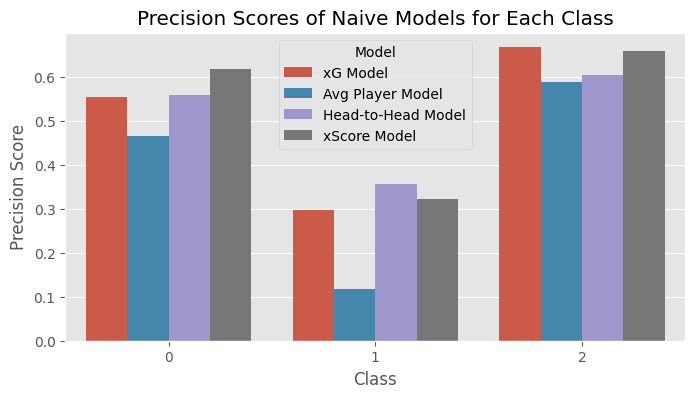

In [192]:
precision_data = pd.DataFrame({
    'Class': np.arange(len(precision_xg)),
    'xG Model': precision_xg,
    'Avg Player Model': precision_avg_player,
    'Head-to-Head Model': precision_h2h,
    'xScore Model': precision_xscore
})

# Melt the DataFrame to have a long-form format for seaborn
precision_data_melted = precision_data.melt(id_vars='Class', var_name='Model', value_name='Precision')

# Plotting
plt.figure(figsize=(8,4))
sns.barplot(data=precision_data_melted, x='Class', y='Precision', hue='Model')
plt.title('Precision Scores of Naive Models for Each Class')
plt.xlabel('Class')
plt.ylabel('Precision Score')
plt.legend(title='Model')
plt.show()

## Machine learning models

In [193]:
class BaseModel:
    def __init__(self, classifier , name):
        self.model = classifier   # Initialize the model attribute, which will hold the trained model
        self.name = name
        self.roc_auc_value = 0
        self.roc_curve = []

    # The function train the model and return the time of training the model if Time is True.
    def train(self, X_train, y_train, Time = False):
        self.model.fit(X_train, y_train)

    def test(self, X_test, y_test = y_test):
        y_pred = self.model.predict(X_test)
        return accuracy_score(y_test, y_pred)

    def evaluate_with_cross_validation(self, X, y, scoring='accuracy', cv=5):
        """
        Evaluate the model using k-fold cross-validation.

        Parameters:
        - X: Input features.
        - y: Target labels.
        - scoring: The scoring metric to use (e.g., 'accuracy', 'precision', 'recall', 'f1').
        - cv: Number of cross-validation folds.

        Returns:
        - scores: List of cross-validation scores.
        """
        scores = cross_val_score(self.model, X, y, cv=cv, scoring=scoring)
        return scores
    
    def tune_hyperparameters(self, hyperparameter_grid, X ,y, scoring = "accuracy", cv=5,verbose = 1):
        grid_search = GridSearchCV(estimator=self.model, param_grid=hyperparameter_grid,
                                   return_train_score=True, cv=cv, scoring=scoring, verbose  = verbose, error_score= 'raise')
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        return grid_search.cv_results_['mean_test_score'] # return the mean test of the grid search
    
    def tune_hyperparameters_with_validation_set(self,hyperparameter_grid, X_train, y_train, X_val, y_val):
        """
        function for hyperparameter tuning using a validation set.

        Parameters:
        - hyperparameter_grid: The dictionary of hyperparameters to tune.
        - X_train: Training feature set.
        - y_train: Training target set.
        - X_val: Validation feature set.
        - y_val: Validation target set.

        Returns:
        - best_score: The validation score of the best model.
        """
        best_score = 0
        best_params = None
        best_model = None
        print(f'start tune_hyperparameters with {self.name}')
        for params in ParameterGrid(hyperparameter_grid):
            curr_model = clone(self.model)
            curr_model.set_params(**params)

            curr_model.fit(X_train, y_train)
            y_val_pred = curr_model.predict(X_val)
            val_score = accuracy_score(y_val, y_val_pred)
            if val_score > best_score:
                best_score = val_score
                best_params = params
                best_model = curr_model
        self.model = best_model
        return best_score

### Functions for evaluations

In [240]:
def compareAccuracy(data):
    # Convert list of dictionaries to DataFrame
    dfAcc = pd.DataFrame(data)
    
    # Plot results
    plt.figure(figsize=(8, 4))
    bar_width = 0.25
    feature_selections = dfAcc['Feature Selection'].unique()
    index = range(len(feature_selections))

    # Plot original accuracies
    plt.bar(index, dfAcc[dfAcc['Accuracy'].notnull()]['Accuracy'], bar_width, label='Original Accuracy')

    # Plot resampled accuracies
    plt.bar([p + bar_width for p in index], dfAcc[dfAcc['Accuracy Resampled'].notnull()]['Accuracy Resampled'], bar_width, label='Resampled Accuracy')

    plt.xlabel('Feature Selection Method')
    plt.ylabel('Accuracy')
    plt.ylim(0.25)
    plt.xticks([p + bar_width / 2 for p in index], feature_selections, rotation=40)
    
    plt.title('Accuracy Comparison by Feature Selection Method')
    plt.legend(title='Accuracy Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    
def comparePrecision(data, classToCompare):
    # Convert list of dictionaries to DataFrame
    dfAcc = pd.DataFrame(data)
    
    # Plot results
    plt.figure(figsize=(8, 4))
    bar_width = 0.25
    feature_selections = dfAcc['Feature Selection'].unique()
    index = range(len(feature_selections))

    # Plot original accuracies
    plt.bar(index, dfAcc[dfAcc[f'precision{classToCompare}'].notnull()][f'precision{classToCompare}'], bar_width, label='Original Precision')

    # Plot resampled accuracies
    plt.bar([p + bar_width for p in index], dfAcc[dfAcc[f'precision{classToCompare} Resampled'].notnull()][f'precision{classToCompare} Resampled'], bar_width, label='Resampled Precision')

    plt.xlabel('Feature Selection Method')
    plt.ylabel('Precision')
    plt.ylim(0.25)
    plt.xticks([p + bar_width / 2 for p in index], feature_selections, rotation=40)
    
    plt.title(f'Precision Comparison of class {classToCompare} by Feature Selection Method')
    plt.legend(title='Precision Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [195]:
def plot_confusion_matrix(y_test,y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred )
    # Create a heatmap of the confusion matrixt
    plt.figure(figsize=(4, 2))
    labels = ['Win','Tie','Loss']
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix')
    plt.tight_layout()
    plt.show()
    

def plot_confusion_for_models(models):
    num_fs = len(allFS)
    fig, axes = plt.subplots(1, num_fs, figsize=(30, 5))

    for i, (ax, mod) in enumerate(zip(axes, models)):
        y_pred = mod.model.predict(allFS[i].newX_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        labels = ['Win','Tie','Loss']

        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax, annot_kws={"size": 25})

        ax.set_title(f"{allFS[i].name}", fontsize =26)
        ax.set_xlabel('Predicted Labels', fontsize =25)
        ax.set_ylabel('True Labels', fontsize =25)
        ax.tick_params(axis='both', which='major', labelsize=18)

    fig.suptitle('Confusion Matrix Comparison for Different Feature Selection Methods', fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()

In [196]:
model_accuracies = []
models = []

In [197]:
all_acc = {}

## One-vs-Rest (OvR) Logistic Regression

In [ ]:
    y_pred = feature_selection.DT.model.predict(feature_selection.newX_test)
    
    test_score  =  accuracy_score(y_test, y_pred)
    precision_all = precision_score(y_test, y_pred, average=None)

    feature_selection.DTResample=  BaseModel(classifier = DecisionTreeClassifier(random_state=42) ,name= "DT Resampled")
    feature_selection.DTResample.train(feature_selection.newX_resampled,y_resampled)
    y_pred_res = feature_selection.DTResample.model.predict(feature_selection.newX_test)
    
    test_score_res  =  accuracy_score(y_test, y_pred_res)
    precision_all_res = precision_score(y_test, y_pred_res,average=None)

    DT_acc.append({'Feature Selection': feature_selection.name,
                   'Accuracy': test_score, 'Accuracy Resampled':test_score_res,
                   'precision-1': precision_all[0],'precision0': precision_all[1],'precision1': precision_all[2],
                   'precision-1 Resampled': precision_all_res[0],
                    'precision0 Resampled': precision_all_res[1],'precision1 Resampled': precision_all_res[2]})

In [248]:
LR_acc = []
for feature_selection in allFS:
    feature_selection.LR= BaseModel(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear',class_weight='balanced')) ,name= "Logistic Regression")
    
    feature_selection.LR.train(feature_selection.newX_train,y_train)
    
    feature_selection.LRResample= BaseModel(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear',class_weight='balanced')) ,name= "Logistic Regression Resample")

    feature_selection.LRResample.train(feature_selection.newX_resampled,y_resampled)
    
    y_pred = feature_selection.LR.model.predict(feature_selection.newX_test)
    
    test_score  =  accuracy_score(y_test, y_pred)
    precision_all = precision_score(y_test, y_pred, average=None)

    y_pred_res = feature_selection.LRResample.model.predict(feature_selection.newX_test)
    
    test_score_res  =  accuracy_score(y_test, y_pred_res)
    precision_all_res = precision_score(y_test, y_pred_res,average=None)

    LR_acc.append({'Feature Selection': feature_selection.name,
                   'Accuracy': test_score, 'Accuracy Resampled':test_score_res,
                   'precision-1': precision_all[0],'precision0': precision_all[1],'precision1': precision_all[2],
                   'precision-1 Resampled': precision_all_res[0],
                    'precision0 Resampled': precision_all_res[1],'precision1 Resampled': precision_all_res[2]})
    
    
    print(f'Accuracy for {feature_selection.name}')
    print(f'Test: {test_score:.5f}, Test on resample data:{test_score_res:.5f}')
    
all_acc['LR']= [LR_acc]

Accuracy for Without FS
Test: 0.59091, Test on resample data:0.58211
Accuracy for correlation FS
Test: 0.58651, Test on resample data:0.58211
Accuracy for RFE FS
Test: 0.58504, Test on resample data:0.58211
Accuracy for Historical
Test: 0.47654, Test on resample data:0.47654
Accuracy for Current
Test: 0.58065, Test on resample data:0.56305
Accuracy for Manual
Test: 0.58504, Test on resample data:0.58651


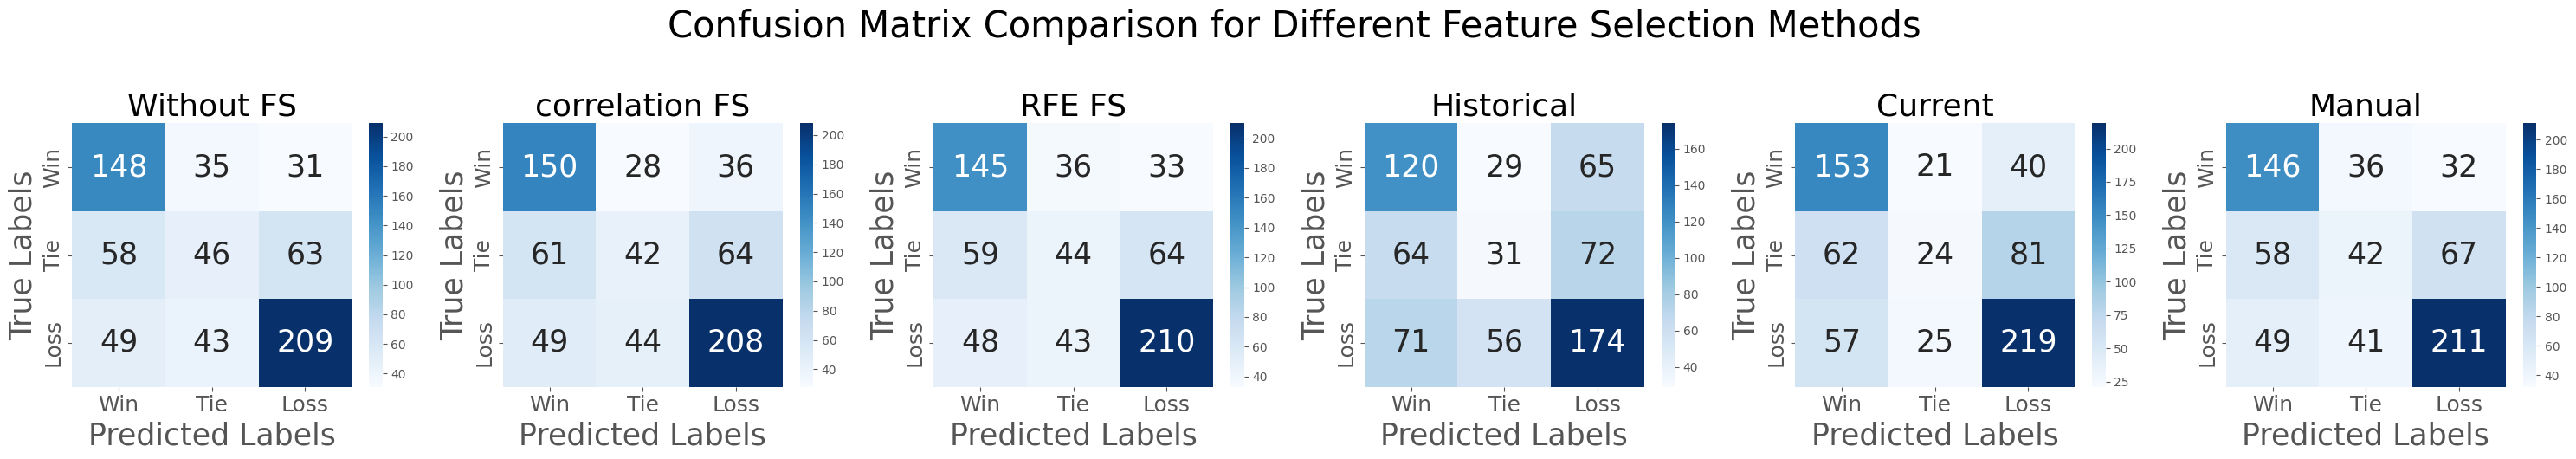

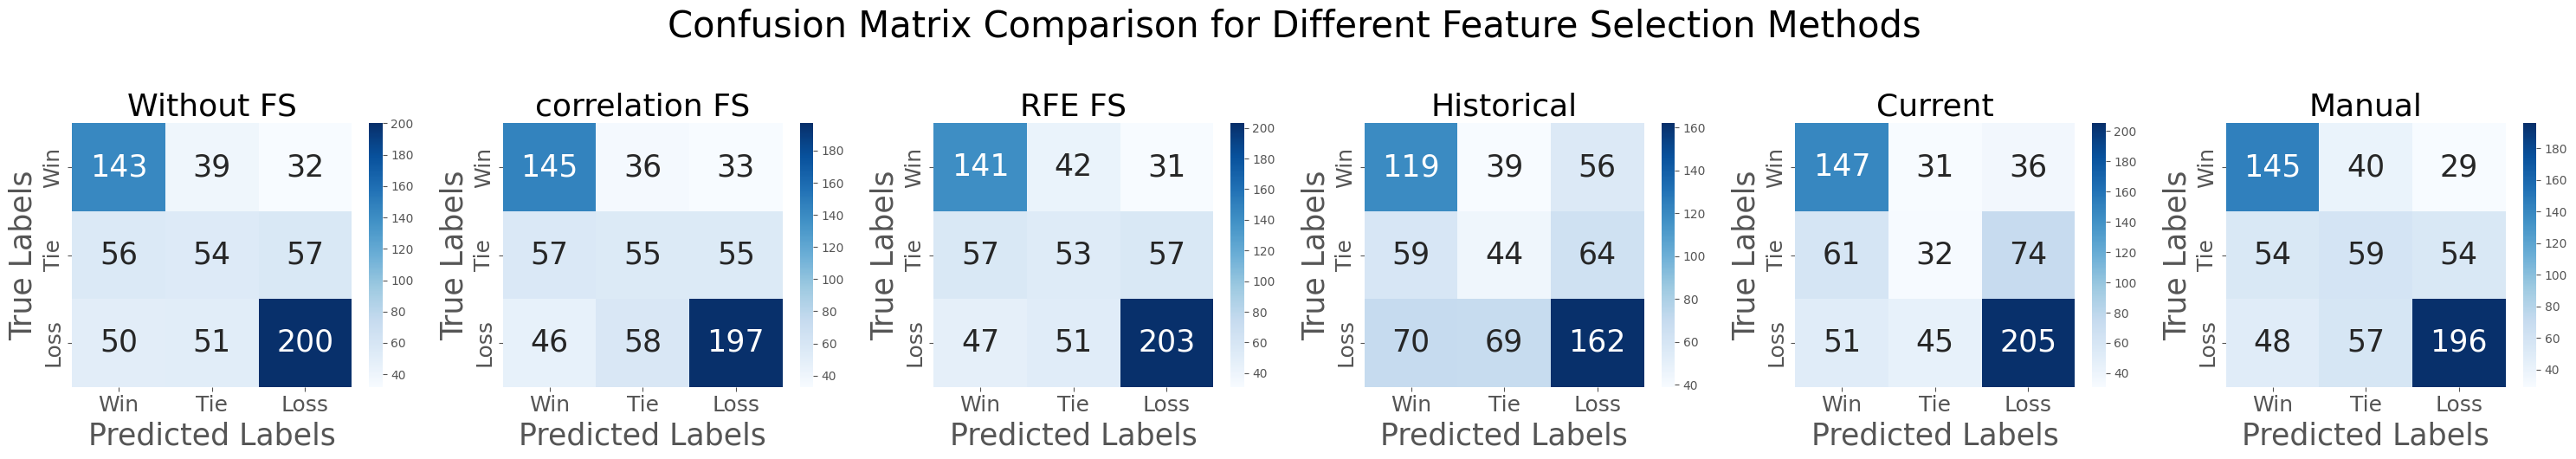

In [199]:
plot_confusion_for_models([Fs.LR for Fs in allFS])
plot_confusion_for_models([Fs.LRResample for Fs in allFS])

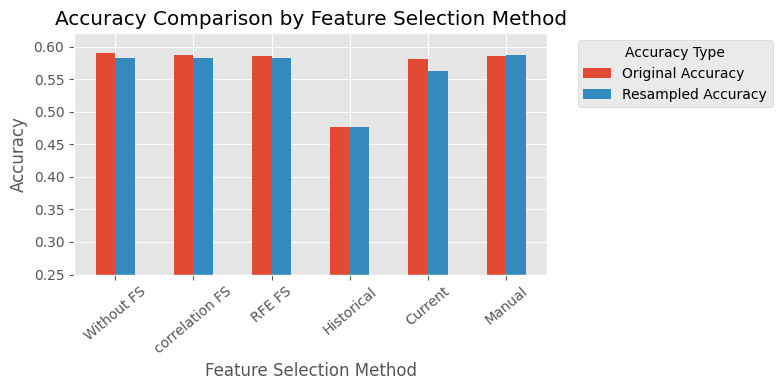

In [200]:
compareAccuracy(LR_acc)


## SVM

In [201]:
%%time
# Define a dictionary of hyperparameters and their possible values
param_grid_SVM = {
    'kernel': ['linear'],
    'C': [0.001,0.01],
    'gamma': [0.01,0.1]
}


best_score_SVM = []
for feature_selection in allFS:
    print(f'Enter {feature_selection.name}')
    ## orginal data
    svm = BaseModel(SVC(probability=True, random_state=42), "SVM")
#     best_score  = max(svm.tune_hyperparameters(param_grid_SVM ,feature_selection.newX_train,y_train))

    best_score = svm.tune_hyperparameters_with_validation_set(
        param_grid_SVM,feature_selection.newX_train, y_train, feature_selection.newX_val, y_val)
    svm.train(feature_selection.newX_train, y_train)
    feature_selection.SVM = svm
    
    ## resample data
    svm_resample = BaseModel(SVC(probability=True, random_state=42, kernel = 'linear',  C=0.1, gamma = 0.1), "SVM Resample")
    svm_resample.train(feature_selection.newX_resampled, y_resampled)

#   best_score_resampled = max(svm.tune_hyperparameters(param_grid_SVM ,feature_selection.newX_resampled,y_resampled,cv = 3, verbose = 3))

#     best_score_resampled = svm_resample.tune_hyperparameters_with_validation_set(
#         param_grid_SVM,feature_selection.newX_resampled, y_resampled, feature_selection.newX_val, y_val)
    feature_selection.SVMResample = svm_resample
    
    best_score_SVM.append(best_score)

Enter Without FS
start tune_hyperparameters with SVM
Enter correlation FS
start tune_hyperparameters with SVM
Enter RFE FS
start tune_hyperparameters with SVM
Enter Historical
start tune_hyperparameters with SVM
Enter Current
start tune_hyperparameters with SVM
Enter Manual
start tune_hyperparameters with SVM
CPU times: total: 8min 59s
Wall time: 9min 4s


In [202]:
# show the selected hyperparameters
for curr_best_score, feature_selection in  zip(best_score_SVM,allFS):
    print(f"{feature_selection.name}:")
    print(f'\t C: {feature_selection.SVM.model.C}, k: {feature_selection.SVM.model.kernel}, g: {feature_selection.SVM.model.gamma} validation score: {curr_best_score} ')
    print('\t resample model:')
    print(f'\t C: {feature_selection.SVMResample.model.C}, k: {feature_selection.SVMResample.model.kernel}, g: {feature_selection.SVMResample.model.gamma} validation score ')


Without FS:
	 C: 0.01, k: linear, g: 0.01 validation score: 0.5505124450951684 
	 resample model:
	 C: 0.1, k: linear, g: 0.1 validation score 
correlation FS:
	 C: 0.01, k: linear, g: 0.01 validation score: 0.5505124450951684 
	 resample model:
	 C: 0.1, k: linear, g: 0.1 validation score 
RFE FS:
	 C: 0.01, k: linear, g: 0.01 validation score: 0.5431918008784773 
	 resample model:
	 C: 0.1, k: linear, g: 0.1 validation score 
Historical:
	 C: 0.01, k: linear, g: 0.01 validation score: 0.5080527086383602 
	 resample model:
	 C: 0.1, k: linear, g: 0.1 validation score 
Current:
	 C: 0.01, k: linear, g: 0.01 validation score: 0.5505124450951684 
	 resample model:
	 C: 0.1, k: linear, g: 0.1 validation score 
Manual:
	 C: 0.01, k: linear, g: 0.01 validation score: 0.5519765739385066 
	 resample model:
	 C: 0.1, k: linear, g: 0.1 validation score 


In [246]:
SVM_acc= []
for feature_selection in allFS:
    y_pred = feature_selection.SVM.model.predict(feature_selection.newX_test)
    test_score  =  accuracy_score(y_test, y_pred)
    precision_all = precision_score(y_test, y_pred, average=None)

    y_pred_res = feature_selection.SVMResample.model.predict(feature_selection.newX_test)

    
    test_score_res  =  accuracy_score(y_test, y_pred_res)
    precision_all_res = precision_score(y_test, y_pred_res,average=None)
    
    SVM_acc.append({'Feature Selection': feature_selection.name,
                   'Accuracy': test_score, 'Accuracy Resampled':test_score_res,
                   'precision-1': precision_all[0],'precision0': precision_all[1],'precision1': precision_all[2],
                   'precision-1 Resampled': precision_all_res[0],
                    'precision0 Resampled': precision_all_res[1],'precision1 Resampled': precision_all_res[2]})
    
    print(f'Accuracy for {feature_selection.name}')
    print(f'Test: {test_score:.5f}, Test on resample data:{test_score_res:.5f}')
    print()
    
all_acc['SVM']= [SVM_acc]

C:\Users\Gadi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for Without FS
Test: 0.58358, Test on resample data:0.56598


C:\Users\Gadi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for correlation FS
Test: 0.58358, Test on resample data:0.58504


C:\Users\Gadi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for RFE FS
Test: 0.55572, Test on resample data:0.54985


C:\Users\Gadi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for Historical
Test: 0.51320, Test on resample data:0.48387


C:\Users\Gadi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for Current
Test: 0.58358, Test on resample data:0.58651

Accuracy for Manual
Test: 0.58211, Test on resample data:0.58798


C:\Users\Gadi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can see that the model does predict ties on the orginal data, lets see if it change on the resampled data

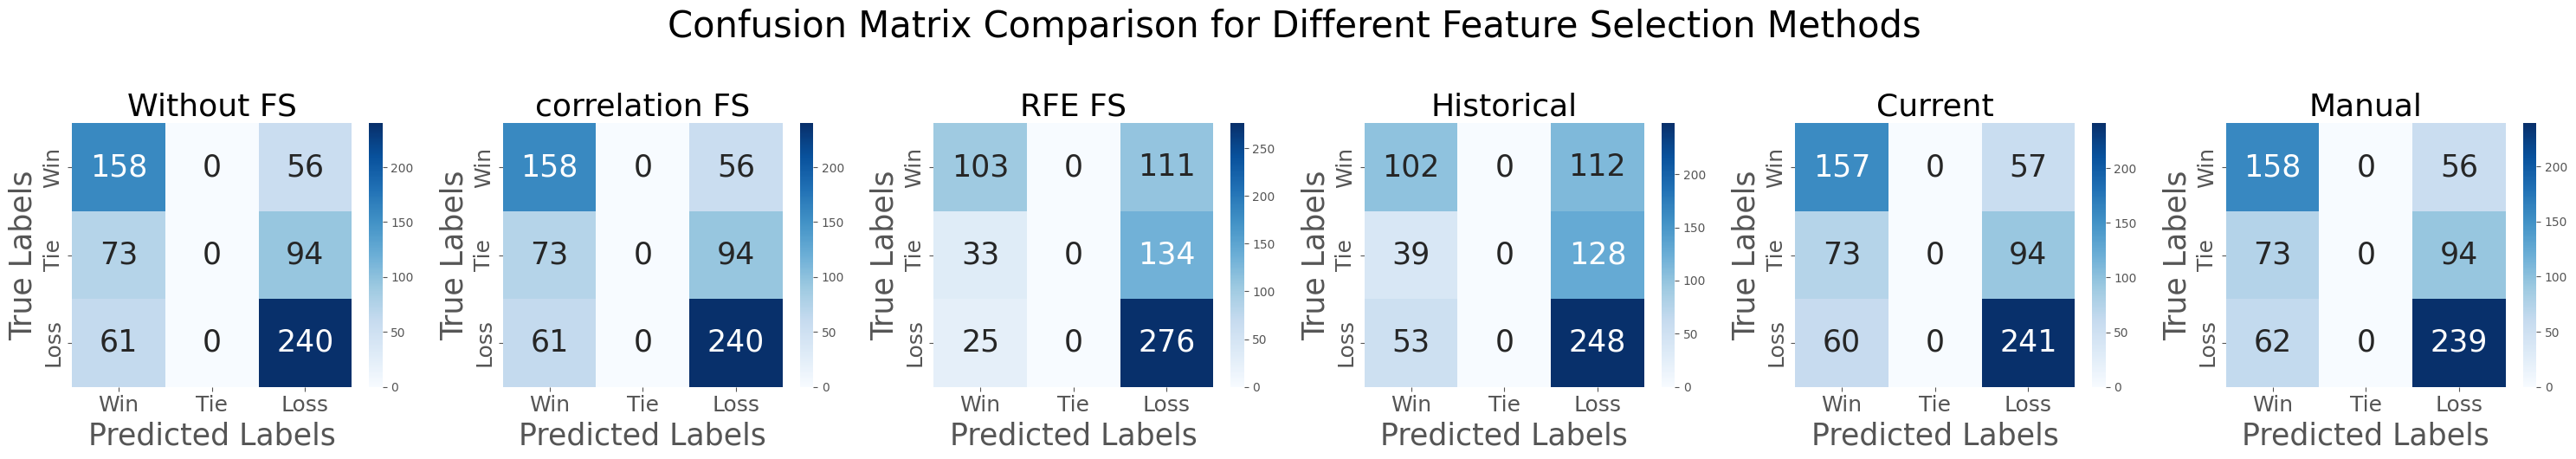

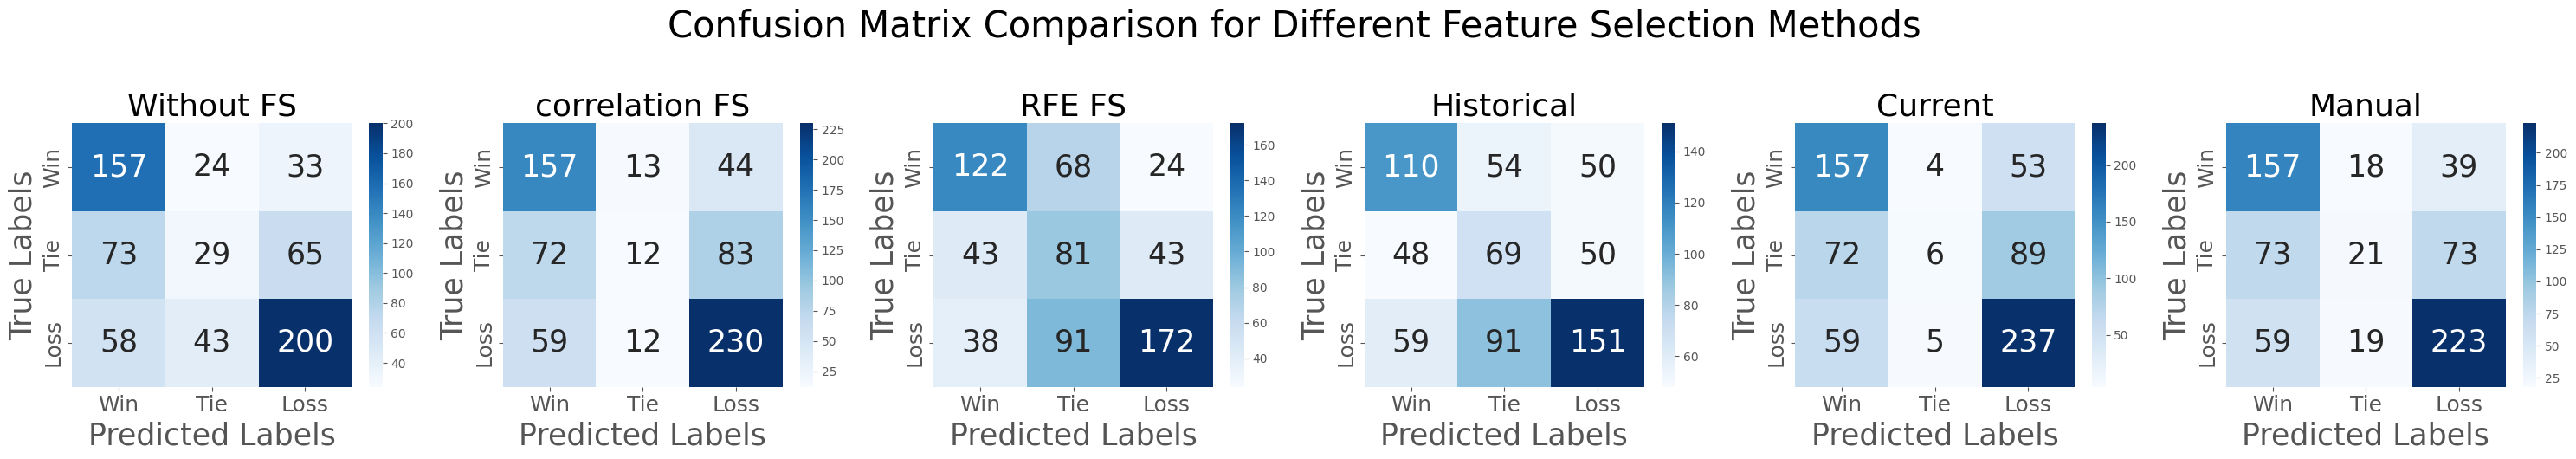

In [204]:
plot_confusion_for_models([Fs.SVM for Fs in allFS])
plot_confusion_for_models([Fs.SVMResample for Fs in allFS])

We can see that now the model predict also ties

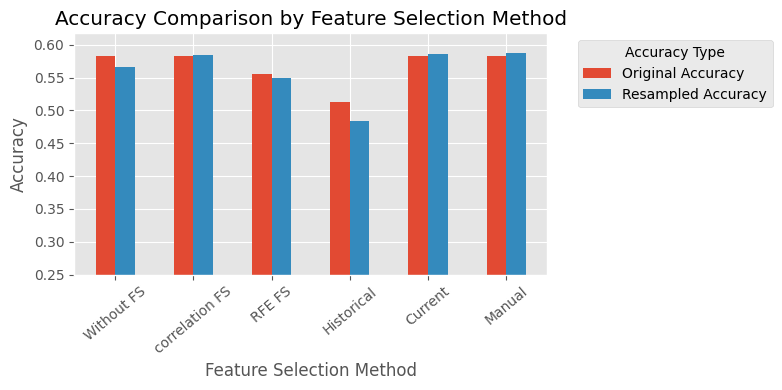

In [205]:
compareAccuracy(SVM_acc)

## KNN

In [206]:
maxK = 120
knn_grid = {'n_neighbors': range(1, maxK+1), 'metric': ['euclidean']}
best_score_KNN = []
for feature_selection in allFS:
    ## orginal data
    knn = BaseModel(KNeighborsClassifier(), "KNN")
    best_score = knn.tune_hyperparameters_with_validation_set(
        knn_grid,feature_selection.newX_train, y_train, feature_selection.newX_val, y_val)
    feature_selection.KNN = knn
    
    ## resample data
    knn_resample = BaseModel(KNeighborsClassifier(), "KNN Resample")
    best_score_resampled = knn_resample.tune_hyperparameters_with_validation_set(
        knn_grid,feature_selection.newX_resampled, y_resampled, feature_selection.newX_val, y_val)
    feature_selection.KNNResample = knn_resample
    
    best_score_KNN.append([best_score,best_score_resampled])

start tune_hyperparameters with KNN
start tune_hyperparameters with KNN Resample
start tune_hyperparameters with KNN
start tune_hyperparameters with KNN Resample
start tune_hyperparameters with KNN
start tune_hyperparameters with KNN Resample
start tune_hyperparameters with KNN
start tune_hyperparameters with KNN Resample
start tune_hyperparameters with KNN
start tune_hyperparameters with KNN Resample
start tune_hyperparameters with KNN
start tune_hyperparameters with KNN Resample


In [207]:
# show the selected hyperparameters
for curr_best_score, feature_selection in zip (best_score_KNN,allFS):
    print(f"{feature_selection.name}:")
    print(f'Best Accuracy on validation with KNN (k = {feature_selection.KNN.model.n_neighbors})  {curr_best_score[0]:.5f}')    
    print('resample model:')
    print(f'Best Accuracy on validation with KNN (k = {feature_selection.KNNResample.model.n_neighbors})  {curr_best_score[1]:.5f}')    
    print()

Without FS:
Best Accuracy on validation with KNN (k = 57)  0.46559
resample model:
Best Accuracy on validation with KNN (k = 91)  0.40849

correlation FS:
Best Accuracy on validation with KNN (k = 7)  0.54758
resample model:
Best Accuracy on validation with KNN (k = 36)  0.54173

RFE FS:
Best Accuracy on validation with KNN (k = 29)  0.56955
resample model:
Best Accuracy on validation with KNN (k = 97)  0.55344

Historical:
Best Accuracy on validation with KNN (k = 115)  0.51684
resample model:
Best Accuracy on validation with KNN (k = 94)  0.46999

Current:
Best Accuracy on validation with KNN (k = 53)  0.54173
resample model:
Best Accuracy on validation with KNN (k = 15)  0.51245

Manual:
Best Accuracy on validation with KNN (k = 112)  0.54466
resample model:
Best Accuracy on validation with KNN (k = 18)  0.52123


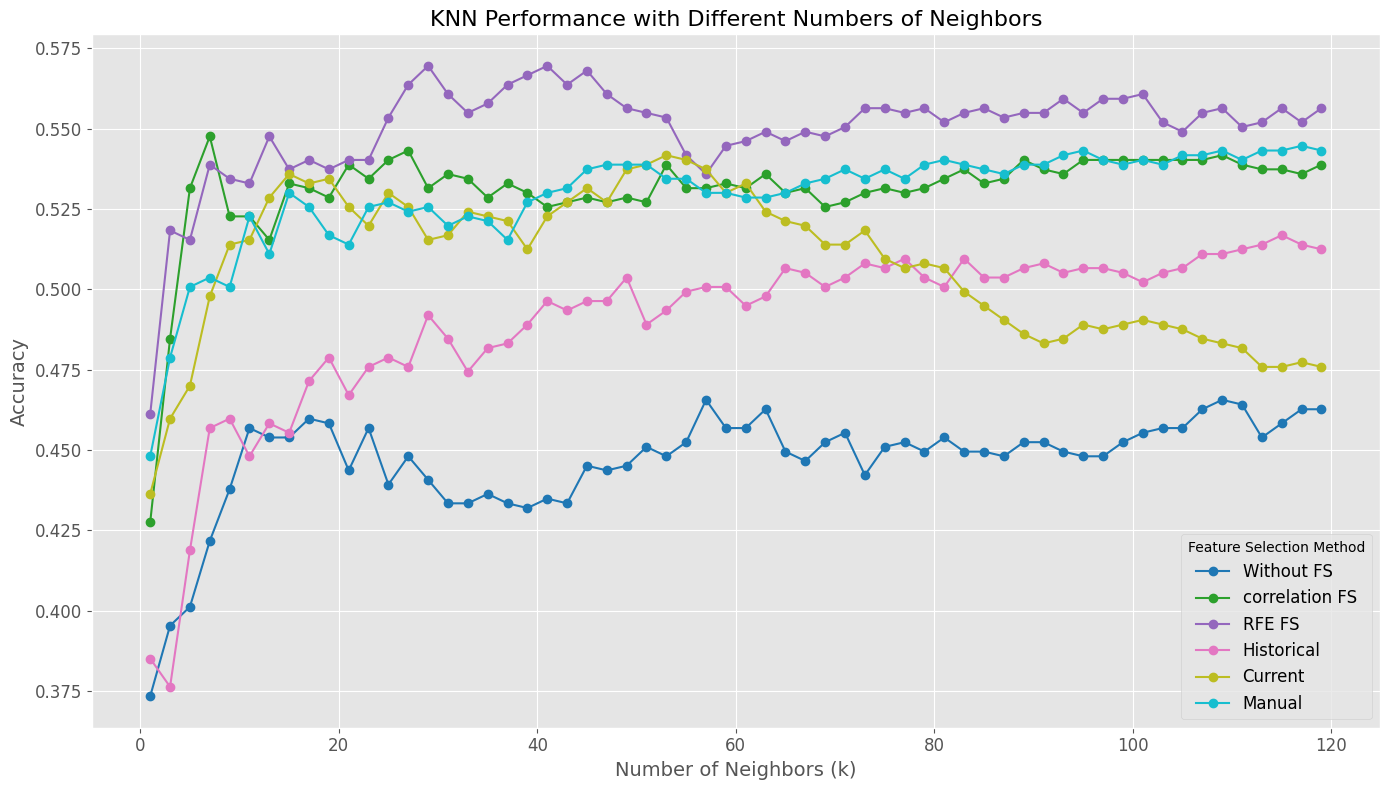

In [208]:
plt.figure(figsize=(14, 8))

neighbors = list(range(1, maxK + 1, 2))
colors = plt.get_cmap('tab10', len(allFS))

for idx, feature_selection in enumerate(allFS):
    scores = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(feature_selection.newX_train, y_train)
        score = knn.score(feature_selection.newX_val, y_val)
        scores.append(score)

    plt.plot(neighbors, scores, marker='o', label=feature_selection.name, color=colors(idx))

plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('KNN Performance with Different Numbers of Neighbors', fontsize=16)
plt.legend(title='Feature Selection Method', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [245]:
KNN_acc= []
for feature_selection in allFS:
    y_pred = feature_selection.KNN.model.predict(feature_selection.newX_test)
    test_score  =  accuracy_score(y_test, y_pred)
    precision_all = precision_score(y_test, y_pred, average=None)

    y_pred_res = feature_selection.KNNResample.model.predict(feature_selection.newX_test)
    
    test_score_res  =  accuracy_score(y_test, y_pred_res)
    precision_all_res = precision_score(y_test, y_pred_res,average=None)
    
    KNN_acc.append({'Feature Selection': feature_selection.name,
                   'Accuracy': test_score, 'Accuracy Resampled':test_score_res,
                   'precision-1': precision_all[0],'precision0': precision_all[1],'precision1': precision_all[2],
                   'precision-1 Resampled': precision_all_res[0],
                    'precision0 Resampled': precision_all_res[1],'precision1 Resampled': precision_all_res[2]})
    
    print(f'Accuracy for {feature_selection.name}')
    print(f'Test: {test_score:.5f}, Test on resample data:{test_score_res:.5f}')
    print()
    
all_acc['KNN']= [KNN_acc]

Accuracy for Without FS
Test: 0.49413, Test on resample data:0.41349

Accuracy for correlation FS
Test: 0.52199, Test on resample data:0.53226

Accuracy for RFE FS
Test: 0.56598, Test on resample data:0.54399

Accuracy for Historical
Test: 0.49413, Test on resample data:0.43842

Accuracy for Current
Test: 0.54692, Test on resample data:0.52786

Accuracy for Manual
Test: 0.58065, Test on resample data:0.53226


We can see that the model does predict ties on the orginal data, lets see if it change on the resampled data

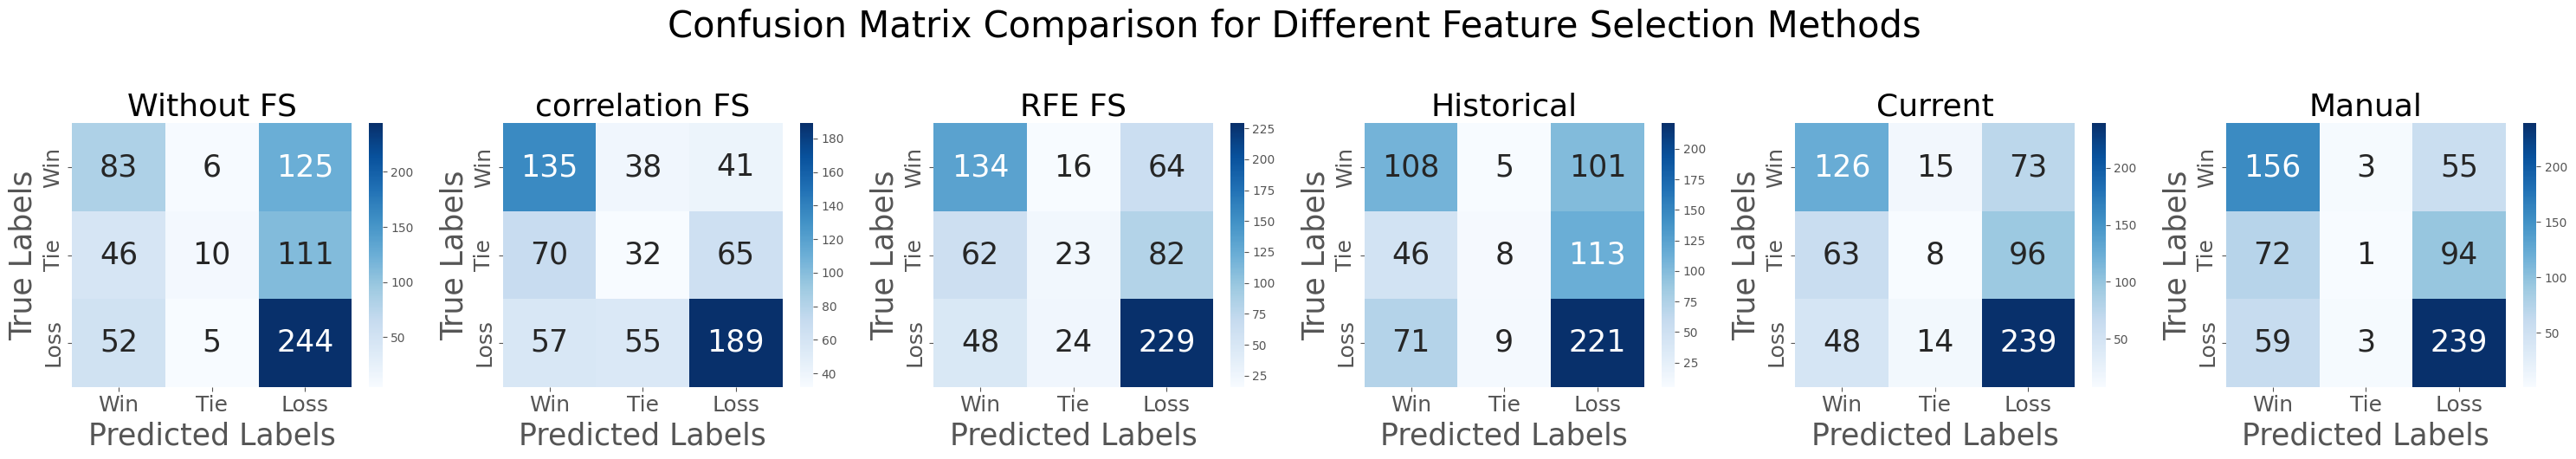

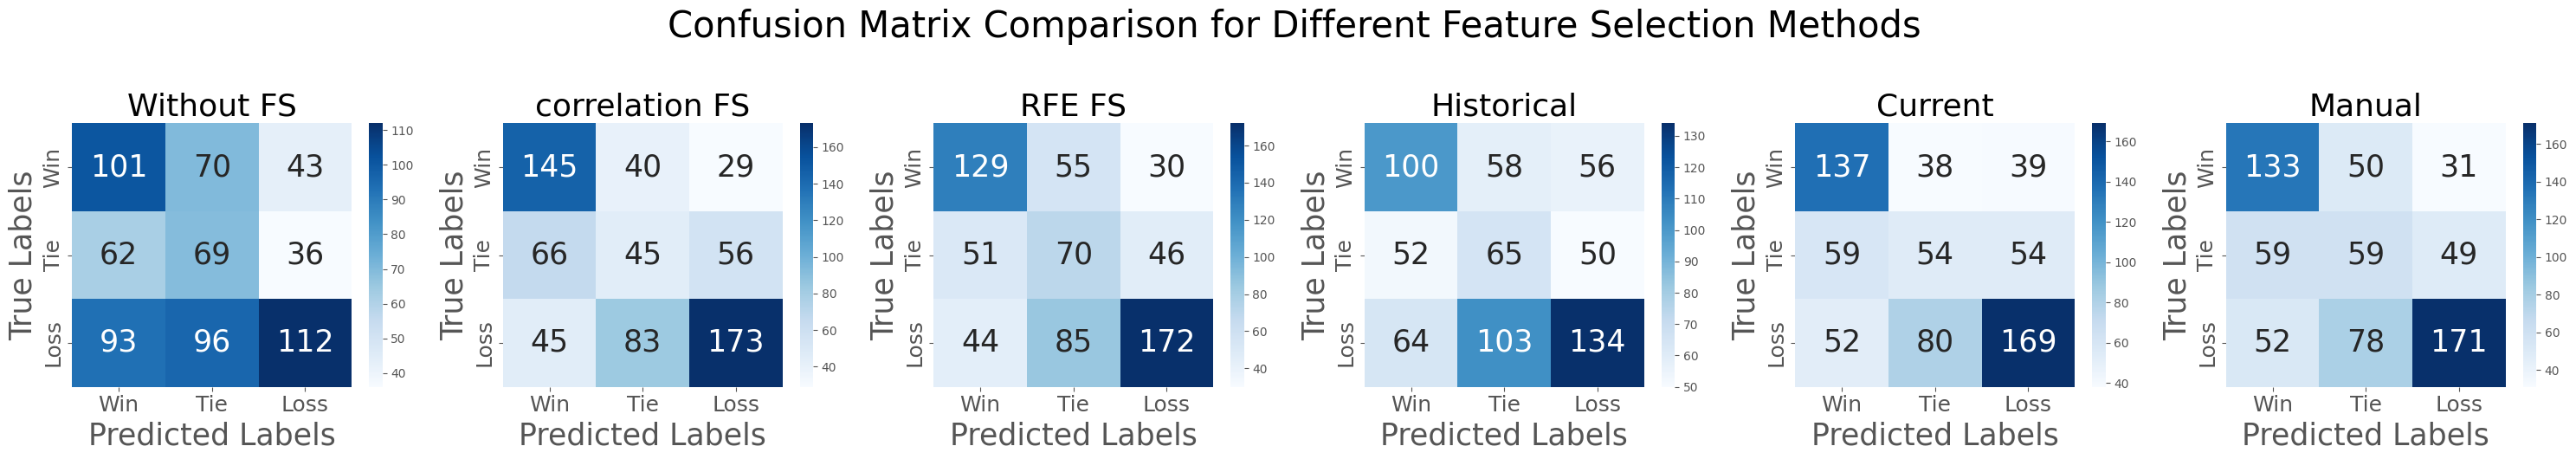

In [210]:
plot_confusion_for_models([Fs.KNN for Fs in allFS])
plot_confusion_for_models([Fs.KNNResample for Fs in allFS])

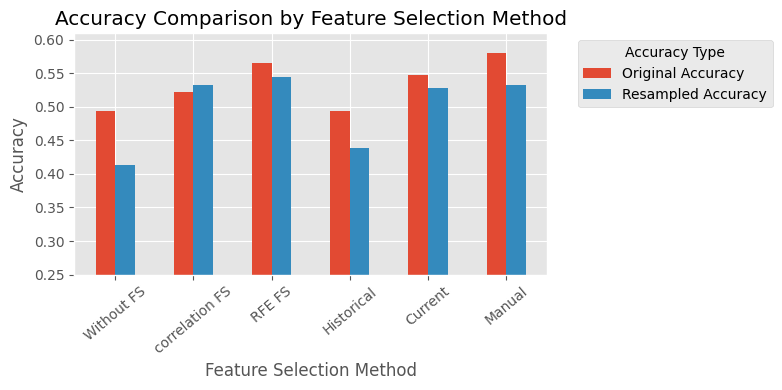

In [211]:
compareAccuracy(KNN_acc)

## Decision tree

In [238]:
DT_acc = []
for feature_selection in allFS:
    feature_selection.DT=  BaseModel(classifier = DecisionTreeClassifier(random_state=42) ,name= "DT")
    
    feature_selection.DT.train(feature_selection.newX_train,y_train)
    y_pred = feature_selection.DT.model.predict(feature_selection.newX_test)
    
    test_score  =  accuracy_score(y_test, y_pred)
    precision_all = precision_score(y_test, y_pred, average=None)

    feature_selection.DTResample=  BaseModel(classifier = DecisionTreeClassifier(random_state=42) ,name= "DT Resampled")
    feature_selection.DTResample.train(feature_selection.newX_resampled,y_resampled)
    y_pred_res = feature_selection.DTResample.model.predict(feature_selection.newX_test)
    
    test_score_res  =  accuracy_score(y_test, y_pred_res)
    precision_all_res = precision_score(y_test, y_pred_res,average=None)

    DT_acc.append({'Feature Selection': feature_selection.name,
                   'Accuracy': test_score, 'Accuracy Resampled':test_score_res,
                   'precision-1': precision_all[0],'precision0': precision_all[1],'precision1': precision_all[2],
                   'precision-1 Resampled': precision_all_res[0],
                    'precision0 Resampled': precision_all_res[1],'precision1 Resampled': precision_all_res[2]})
    
    print(f'Accuracy for {feature_selection.name}')
    print(f'Test: {test_score:.5f}, Test on resample data:{test_score_res:.5f}')
    print()
    
all_acc['DT']= [DT_acc]

Accuracy for Without FS
Test: 0.45894, Test on resample data:0.45748

Accuracy for correlation FS
Test: 0.48534, Test on resample data:0.46188

Accuracy for RFE FS
Test: 0.46041, Test on resample data:0.45161

Accuracy for Historical
Test: 0.41056, Test on resample data:0.40616

Accuracy for Current
Test: 0.45015, Test on resample data:0.44135

Accuracy for Manual
Test: 0.45894, Test on resample data:0.44135


In [213]:
for feature_selection in allFS:
    y_pred = feature_selection.DT.model.predict(feature_selection.newX_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"confusion matrix for Desicion tree with {feature_selection.name}: \n {conf_matrix}")
    print(f"accuracy =  {accuracy_score(y_test, y_pred):.5f}")
    
    print()

confusion matrix for Desicion tree with Without FS: 
 [[100  53  61]
 [ 51  51  65]
 [ 65  74 162]]
accuracy =  0.45894

confusion matrix for Desicion tree with correlation FS: 
 [[109  51  54]
 [ 41  52  74]
 [ 50  81 170]]
accuracy =  0.48534

confusion matrix for Desicion tree with RFE FS: 
 [[108  48  58]
 [ 50  43  74]
 [ 49  89 163]]
accuracy =  0.46041

confusion matrix for Desicion tree with Historical: 
 [[ 79  64  71]
 [ 49  60  58]
 [ 87  73 141]]
accuracy =  0.41056

confusion matrix for Desicion tree with Current: 
 [[ 96  54  64]
 [ 53  54  60]
 [ 53  91 157]]
accuracy =  0.45015

confusion matrix for Desicion tree with Manual: 
 [[100  62  52]
 [ 41  49  77]
 [ 65  72 164]]
accuracy =  0.45894


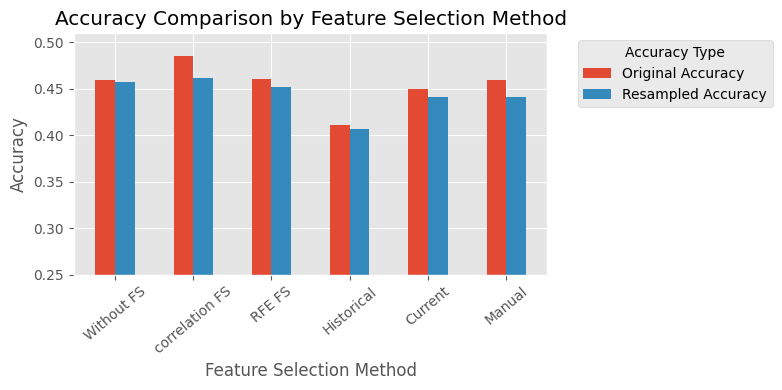

In [214]:
compareAccuracy(DT_acc)

We got poor results compare to other models. The reason for this is probably the overfitting that occurs when using Descion Trees. The tree fits perfectly for the training data, and does not have the flexibility for changes which occur in the test set data.

## Random Forest

start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Random Forest
start tune_hyperparameters with Ra

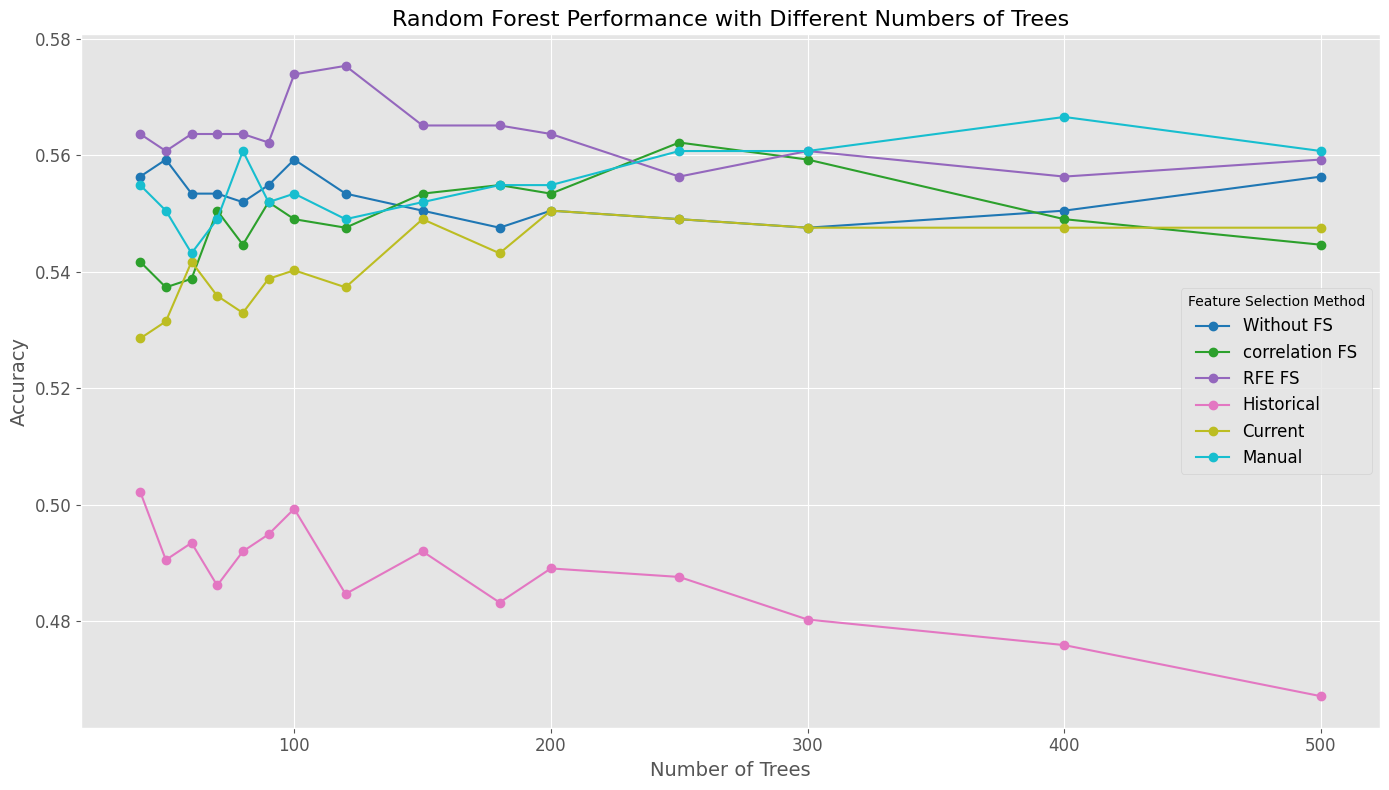

In [215]:

param_grid_RF = {
    'n_estimators': [40,50,60,70,80,90,100,120,150,180,200,250,300,400,500],
}

# Initialize the Random Forest model
rf = BaseModel(RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42), "Random Forest")

plt.figure(figsize=(14, 8))
colors = plt.get_cmap('tab10', len(allFS))

for idx, feature_selection in enumerate(allFS):
    accuracies_RF = []
    for n_estimators in param_grid_RF['n_estimators']:
        rf.model.set_params(n_estimators=n_estimators)
        accuracy = rf.tune_hyperparameters_with_validation_set({'n_estimators': [n_estimators]}, feature_selection.newX_train, y_train, feature_selection.newX_val, y_val)
        accuracies_RF.append(accuracy)
    plt.plot(param_grid_RF['n_estimators'], accuracies_RF, marker='o', label=feature_selection.name, color=colors(idx))

plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Random Forest Performance with Different Numbers of Trees', fontsize=16)
plt.legend(title='Feature Selection Method', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [216]:
%%time
new_param_grid_RF = {
    'n_estimators': [60,70,80,90,100,120],
    'max_features' : [None,7,0.5,0.1],
    'min_samples_leaf' : [20,25,30]
}

best_score_RF = []
for feature_selection in allFS:
    ## orginal data

    rf =  BaseModel(RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42 ), "RF")
    best_score = rf.tune_hyperparameters_with_validation_set(
        new_param_grid_RF,feature_selection.newX_train, y_train, feature_selection.newX_val, y_val)
    feature_selection.RF = rf
    
    ## resample data
    rf_resample = BaseModel(RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42 ), "RF Resample")
    best_score_resampled = rf_resample.tune_hyperparameters_with_validation_set(
        new_param_grid_RF,feature_selection.newX_resampled, y_resampled, feature_selection.newX_val, y_val)
    feature_selection.RFResample = rf_resample
    
    best_score_RF.append([best_score,best_score_resampled])

start tune_hyperparameters with RF
start tune_hyperparameters with RF Resample
start tune_hyperparameters with RF
start tune_hyperparameters with RF Resample
start tune_hyperparameters with RF
start tune_hyperparameters with RF Resample
start tune_hyperparameters with RF
start tune_hyperparameters with RF Resample
start tune_hyperparameters with RF
start tune_hyperparameters with RF Resample
start tune_hyperparameters with RF
start tune_hyperparameters with RF Resample
CPU times: total: 37min 2s
Wall time: 13min 52s


In [217]:
# Show the selected hyperparameters
for curr_best_score, feature_selection in zip(best_score_RF, allFS):
    print(f"{feature_selection.name}:")
    print(f'\t n_estimators: {feature_selection.RF.model.n_estimators}, '
          f'max_features: {feature_selection.RF.model.max_features}, '
          f'min_samples_leaf: {feature_selection.RF.model.min_samples_leaf}, '
          f'validation score: {curr_best_score[0]:.5f}')
    print('\t resample model:')
    print(f'\t n_estimators: {feature_selection.RFResample.model.n_estimators}, '
          f'max_features: {feature_selection.RFResample.model.max_features}, '
          f'min_samples_leaf: {feature_selection.RFResample.model.min_samples_leaf}, '
          f'validation score: {curr_best_score[1]:.5f}')


Without FS:
	 n_estimators: 100, max_features: 0.5, min_samples_leaf: 30, validation score: 0.56955
	 resample model:
	 n_estimators: 80, max_features: 0.5, min_samples_leaf: 20, validation score: 0.56369
correlation FS:
	 n_estimators: 80, max_features: None, min_samples_leaf: 25, validation score: 0.56369
	 resample model:
	 n_estimators: 80, max_features: None, min_samples_leaf: 30, validation score: 0.56955
RFE FS:
	 n_estimators: 100, max_features: None, min_samples_leaf: 20, validation score: 0.57101
	 resample model:
	 n_estimators: 60, max_features: 0.5, min_samples_leaf: 20, validation score: 0.57833
Historical:
	 n_estimators: 70, max_features: 0.1, min_samples_leaf: 25, validation score: 0.51830
	 resample model:
	 n_estimators: 60, max_features: 0.1, min_samples_leaf: 20, validation score: 0.51245
Current:
	 n_estimators: 100, max_features: None, min_samples_leaf: 20, validation score: 0.56223
	 resample model:
	 n_estimators: 120, max_features: 0.5, min_samples_leaf: 20, v

In [235]:
RF_acc= []
for feature_selection in allFS:
    y_pred = feature_selection.RF.model.predict(feature_selection.newX_test)
    test_score  =  accuracy_score(y_test, y_pred)
    precision_all = precision_score(y_test, y_pred, average=None)

    y_pred_res = feature_selection.RFResample.model.predict(feature_selection.newX_test)
    test_score_res  =  accuracy_score(y_test, y_pred_res)
    precision_all_res = precision_score(y_test, y_pred_res,average=None)

    RF_acc.append({'Feature Selection': feature_selection.name,
                   'Accuracy': test_score, 'Accuracy Resampled':test_score_res,
                   'precision-1': precision_all[0],'precision0': precision_all[1],'precision1': precision_all[2],
                   'precision-1 Resampled': precision_all_res[0],
                    'precision0 Resampled': precision_all_res[1],'precision1 Resampled': precision_all_res[2]})
    
    print(f'Accuracy for {feature_selection.name}')
    print(f'Test: {test_score:.5f}, Test on resample data:{test_score_res:.5f}')
    print()
    
all_acc['RF']= [RF_acc]

Accuracy for Without FS
Test: 0.56891, Test on resample data:0.56305

Accuracy for correlation FS
Test: 0.57625, Test on resample data:0.54399

Accuracy for RFE FS
Test: 0.57625, Test on resample data:0.56745

Accuracy for Historical
Test: 0.51026, Test on resample data:0.49413

Accuracy for Current
Test: 0.58065, Test on resample data:0.58798

Accuracy for Manual
Test: 0.56452, Test on resample data:0.56745


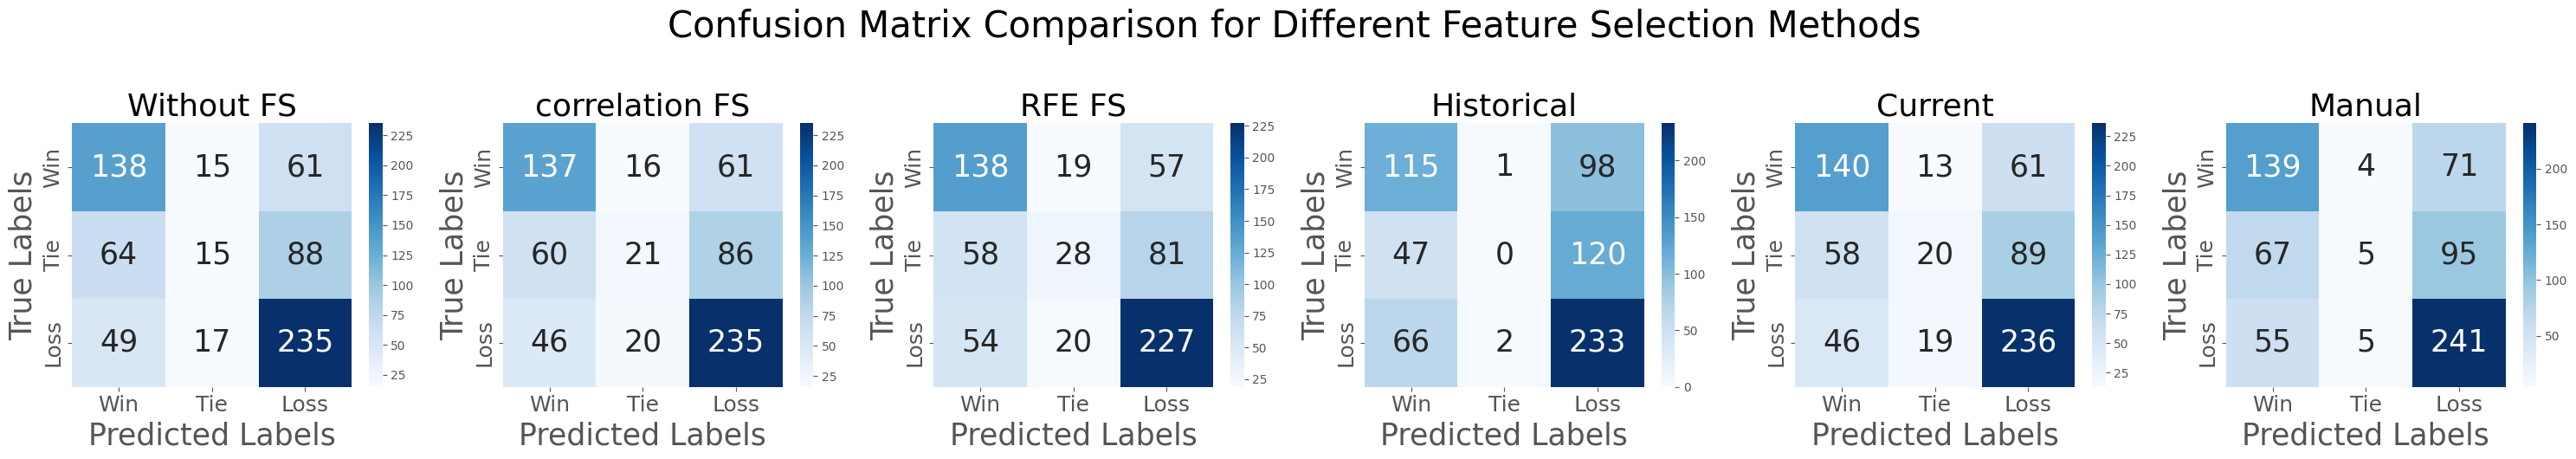

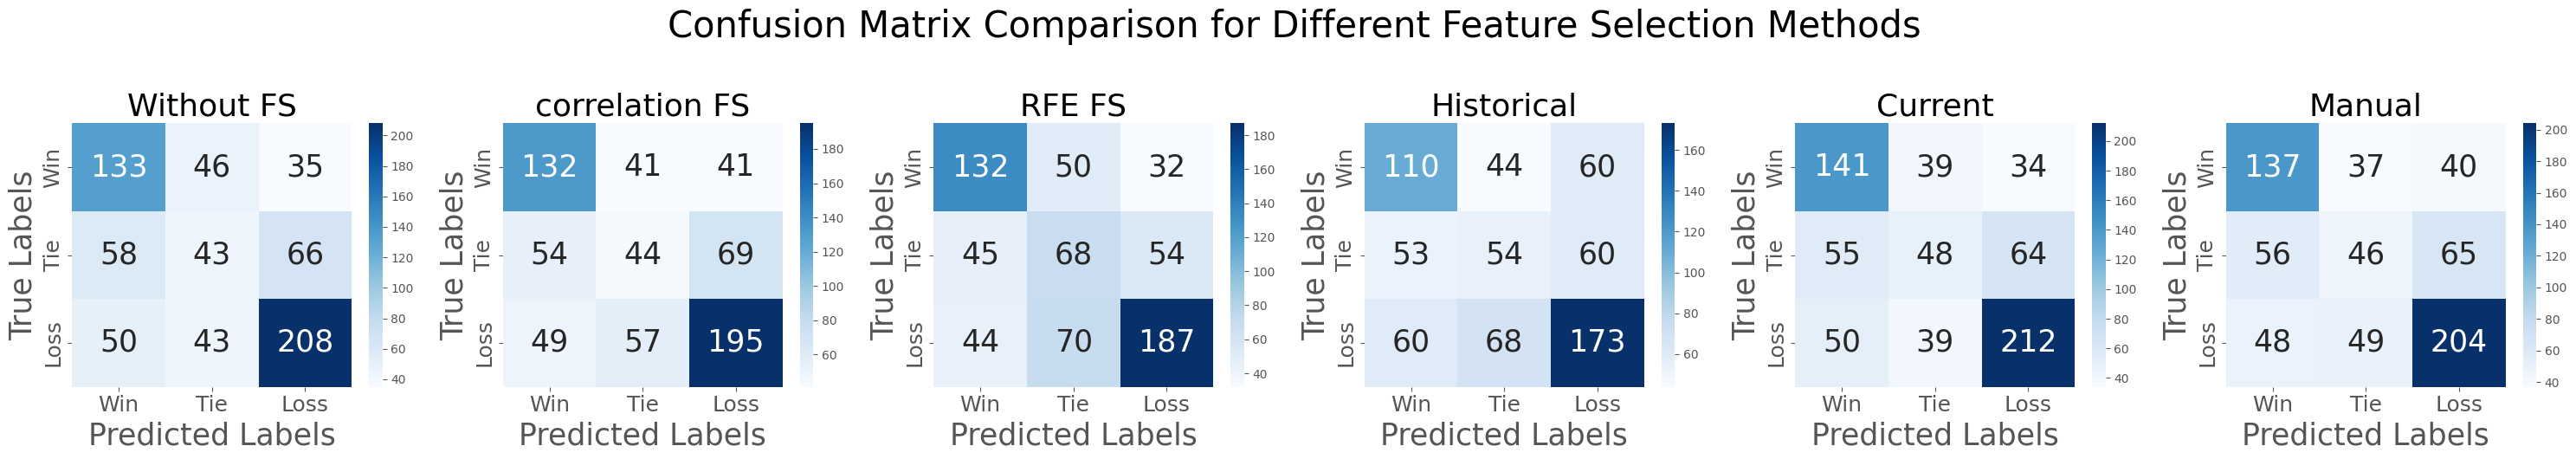

In [219]:
plot_confusion_for_models([Fs.RF for Fs in allFS])
plot_confusion_for_models([Fs.RFResample for Fs in allFS])

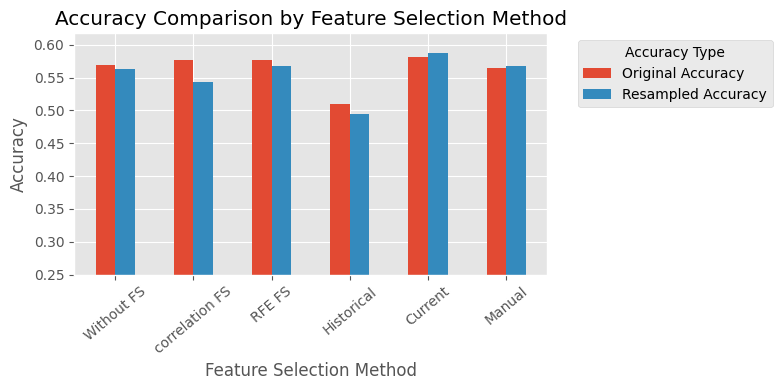

In [220]:
compareAccuracy(RF_acc)

## XGBoost

Fix data for XGB
XGB will be need to accept the labels as: [0,1,2]

In [221]:
y_trainXGB = y_train+1
y_valXGB = y_val+1
y_testXGB = y_test +1
y_resampledXGB = y_resampled + 1

In [222]:
%%time

# Define hyperparameters grid for XGBoost
param_grid_XGB = {
    'n_estimators': [80, 100,120],
    'max_depth': [4, 5,6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8]
}


best_score_XGB = []
for feature_selection in allFS:
    ## orginal data
    xgb = BaseModel(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), "XGB")
    best_score = xgb.tune_hyperparameters_with_validation_set(
        param_grid_XGB,feature_selection.newX_train, y_trainXGB, feature_selection.newX_val, y_valXGB)
    feature_selection.XGB = xgb
    
    ## resample data
    xgb_resample = BaseModel(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), "XGB Resample")
    best_score_resampled = xgb_resample.tune_hyperparameters_with_validation_set(
        param_grid_XGB,feature_selection.newX_resampled, y_resampledXGB, feature_selection.newX_val, y_valXGB)
    feature_selection.XGBResample = xgb_resample
    
    best_score_XGB.append([best_score,best_score_resampled])

start tune_hyperparameters with XGB
start tune_hyperparameters with XGB Resample
start tune_hyperparameters with XGB
start tune_hyperparameters with XGB Resample
start tune_hyperparameters with XGB
start tune_hyperparameters with XGB Resample
start tune_hyperparameters with XGB
start tune_hyperparameters with XGB Resample
start tune_hyperparameters with XGB
start tune_hyperparameters with XGB Resample
start tune_hyperparameters with XGB
start tune_hyperparameters with XGB Resample
CPU times: total: 1h 25min 28s
Wall time: 26min 36s


In [236]:
# Show the selected hyperparameters
for curr_best_score, feature_selection in zip(best_score_XGB, allFS):
    print(f"{feature_selection.name}:")
    print(f'\t n_estimators: {feature_selection.XGB.model.n_estimators}, '
          f'max_depth: {feature_selection.XGB.model.max_depth}, '
          f'learning_rate: {feature_selection.XGB.model.learning_rate}, '
          f'subsample: {feature_selection.XGB.model.subsample}, '
          f'colsample_bytree: {feature_selection.XGB.model.colsample_bytree}, '
          
          f'validation score: {curr_best_score[0]:.5f}')
    print('\t resample model:')
    print(f'\t n_estimators: {feature_selection.XGBResample.model.n_estimators}, '
          f'max_depth: {feature_selection.XGBResample.model.max_depth}, '
          f'learning_rate: {feature_selection.XGBResample.model.learning_rate}, '
          f'subsample: {feature_selection.XGBResample.model.subsample}, '
          f'colsample_bytree: {feature_selection.XGBResample.model.colsample_bytree}, '

          f'validation score: {curr_best_score[1]:.5f}')


Without FS:
	 n_estimators: 100, max_depth: 5, learning_rate: 0.1, subsample: 0.7, colsample_bytree: 0.8, validation score: 0.56808
	 resample model:
	 n_estimators: 120, max_depth: 6, learning_rate: 0.1, subsample: 0.7, colsample_bytree: 0.8, validation score: 0.56955
correlation FS:
	 n_estimators: 80, max_depth: 6, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, validation score: 0.56515
	 resample model:
	 n_estimators: 100, max_depth: 4, learning_rate: 0.01, subsample: 0.8, colsample_bytree: 0.8, validation score: 0.56515
RFE FS:
	 n_estimators: 80, max_depth: 6, learning_rate: 0.01, subsample: 0.7, colsample_bytree: 0.6, validation score: 0.56808
	 resample model:
	 n_estimators: 100, max_depth: 4, learning_rate: 0.01, subsample: 0.6, colsample_bytree: 0.7, validation score: 0.57394
Historical:
	 n_estimators: 100, max_depth: 4, learning_rate: 0.1, subsample: 0.7, colsample_bytree: 0.8, validation score: 0.50659
	 resample model:
	 n_estimators: 80, max_depth: 4, learn

In [237]:
XGB_acc= []
for feature_selection in allFS:
    y_pred = feature_selection.XGB.model.predict(feature_selection.newX_test)
    test_score  =  accuracy_score(y_testXGB, y_pred)
    precision_all = precision_score(y_testXGB, y_pred, average=None)
    y_pred_res = feature_selection.XGBResample.model.predict(feature_selection.newX_test)
    test_score_res  =  accuracy_score(y_testXGB, y_pred_res)
    precision_all_res = precision_score(y_testXGB, y_pred_res,average=None)

    test_resample_score = feature_selection.XGBResample.test(feature_selection.newX_test, y_testXGB)
    XGB_acc.append({'Feature Selection': feature_selection.name,
                   'Accuracy': test_score, 'Accuracy Resampled':test_score_res,
                   'precision-1': precision_all[0],'precision0': precision_all[1],'precision1': precision_all[2],
                   'precision-1 Resampled': precision_all_res[0],
                    'precision0 Resampled': precision_all_res[1],'precision1 Resampled': precision_all_res[2]})
    
    print(f'Accuracy for {feature_selection.name}')
    print(f'Test: {test_score:.5f}, Test on resample data:{test_score_res:.5f}')
    print()
    
all_acc['XGB']= [XGB_acc]

Accuracy for Without FS
Test: 0.56598, Test on resample data:0.57331

Accuracy for correlation FS
Test: 0.57625, Test on resample data:0.57331

Accuracy for RFE FS
Test: 0.57918, Test on resample data:0.57331

Accuracy for Historical
Test: 0.50587, Test on resample data:0.49267

Accuracy for Current
Test: 0.56891, Test on resample data:0.56745

Accuracy for Manual
Test: 0.56745, Test on resample data:0.55132


In [225]:
 def XGB_confusion_matrix(models):
    num_fs = len(allFS)
    fig, axes = plt.subplots(1, num_fs, figsize=(30, 5))

    for i, (ax, mod) in enumerate(zip(axes, models)):
        y_pred = mod.model.predict(allFS[i].newX_test)
        conf_matrix = confusion_matrix(y_testXGB, y_pred)
        labels = ['Win','Tie','Loss']

        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax, annot_kws={"size": 25})

        ax.set_title(f"{allFS[i].name}", fontsize =26)
        ax.set_xlabel('Predicted Labels', fontsize =25)
        ax.set_ylabel('True Labels', fontsize =25)
        ax.tick_params(axis='both', which='major', labelsize=18)

    fig.suptitle('Confusion Matrix Comparison for Different Feature Selection Methods', fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()

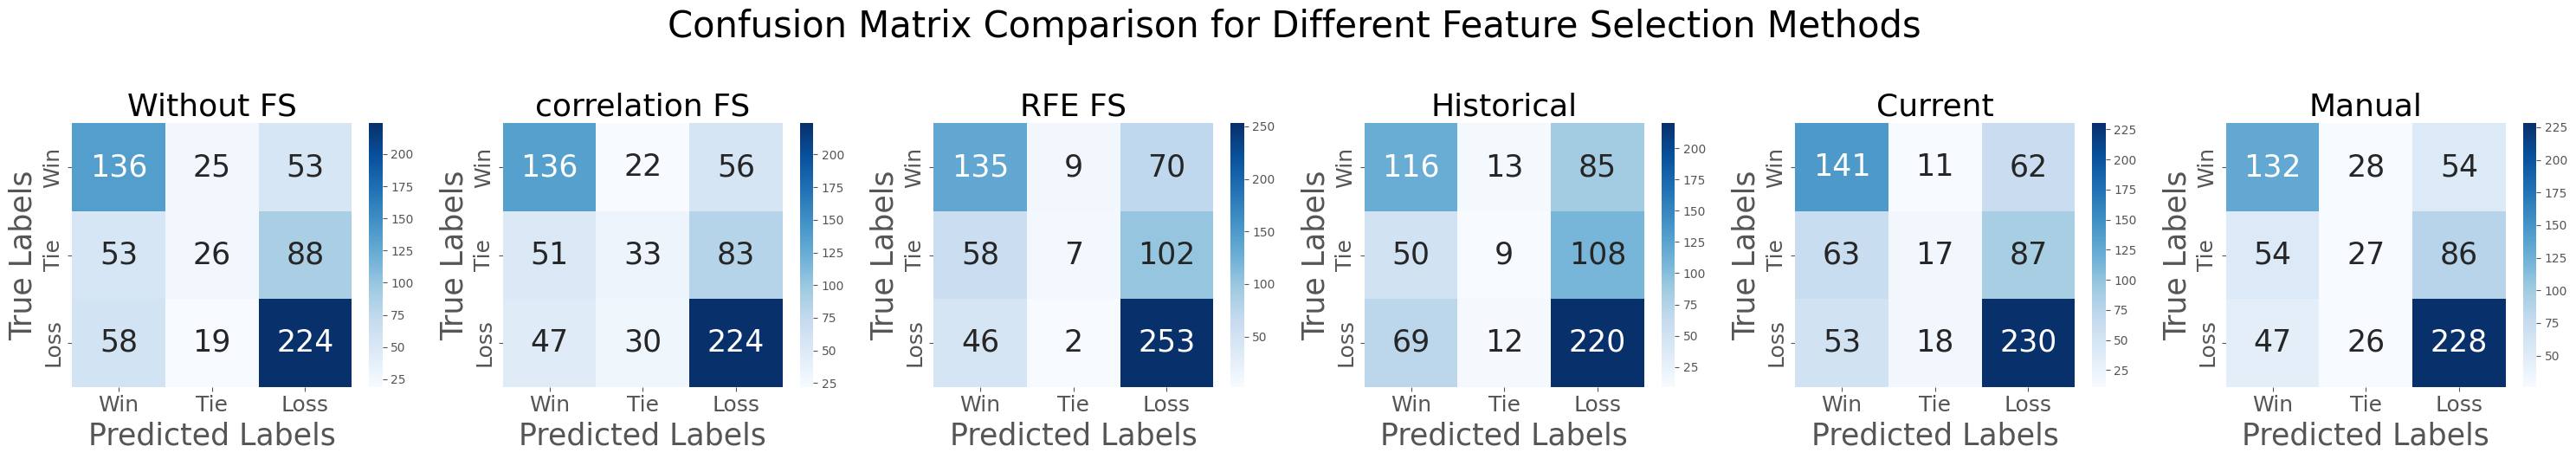

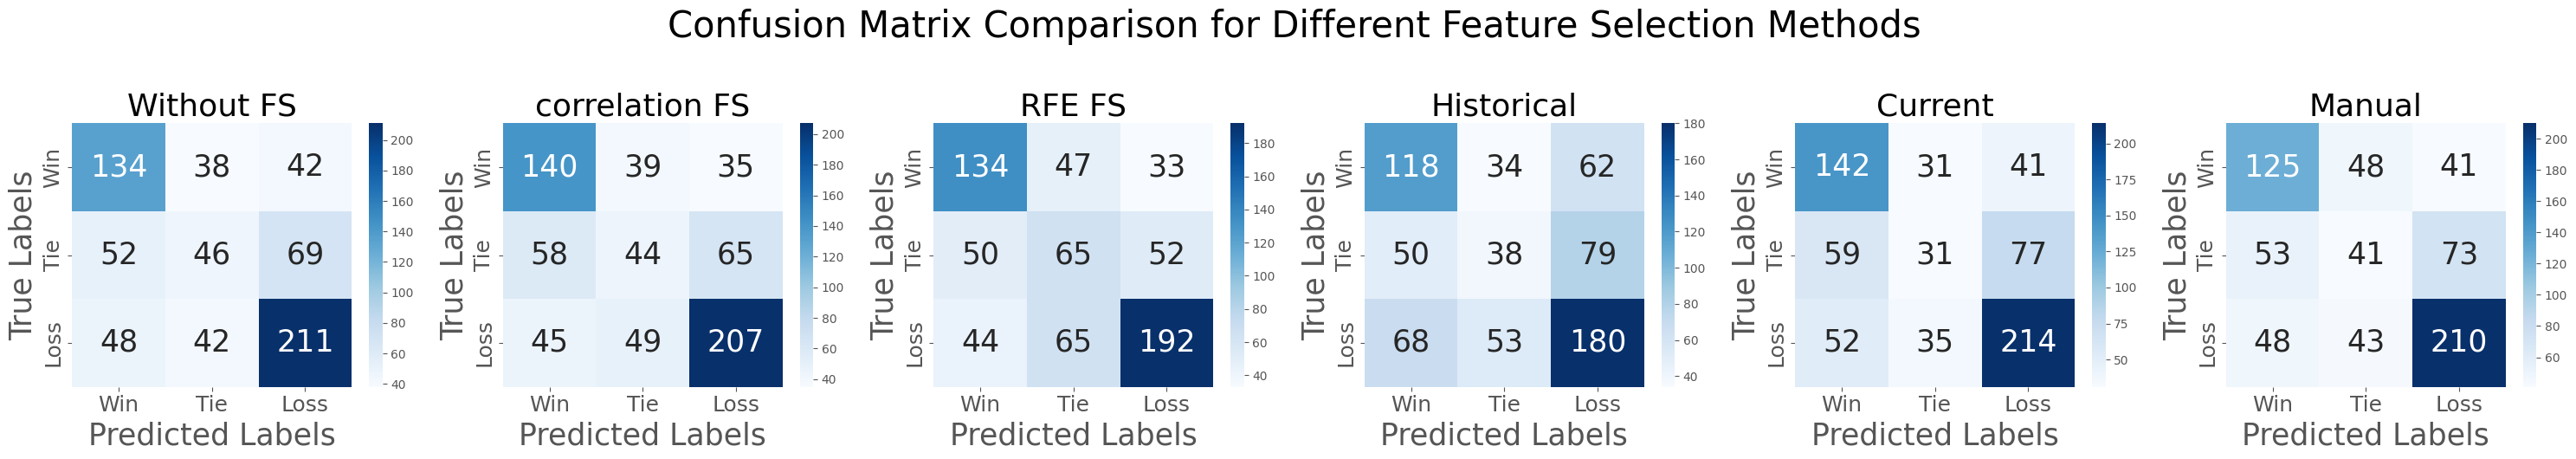

In [226]:
XGB_confusion_matrix([Fs.XGB for Fs in allFS])
XGB_confusion_matrix([Fs.XGBResample for Fs in allFS])

Again we can see that on the resampled results the moedl manage to predict also ties

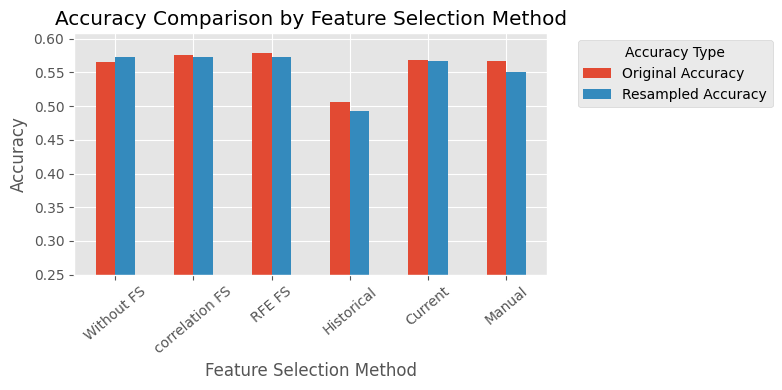

In [304]:
compareAccuracy(XGB_acc)


## Model selection

In [249]:
flat_data = []
for model, results in all_acc.items():
    for result_list in results:
        for result in result_list:
            flat_data.append({
                'Classifier Name': model,
                'Feature Selection': result['Feature Selection'],
                'Accuracy': result['Accuracy'],
                'Accuracy Resampled': result['Accuracy Resampled'],
                'precision-1': result['precision-1'],
                'precision0': result['precision0'],
                'precision1': result['precision1'],
                'precision-1 Resampled': result['precision-1 Resampled'],
                'precision0 Resampled': result['precision0 Resampled'],
                'precision1 Resampled': result['precision0 Resampled'],
                'precision1 Resampled': result['precision1 Resampled']
            })

# Create DataFrame
result_df = pd.DataFrame(flat_data)
result_df = result_df.set_index(['Feature Selection', 'Classifier Name'])
result_df = result_df.sort_index(level=['Feature Selection', 'Classifier Name'])
result_df


Accuracy  Accuracy Resampled  precision-1  \
Feature Selection Classifier Name                                              
Current           DT               0.450147            0.441349     0.475248   
                  KNN              0.546921            0.527859     0.531646   
                  LR               0.580645            0.563050     0.562500   
                  RF               0.580645            0.587977     0.573770   
                  SVM              0.583578            0.586510     0.541379   
                  XGB              0.568915            0.567449     0.548638   
Historical        DT               0.410557            0.406158     0.367442   
                  KNN              0.494135            0.438416     0.480000   
                  LR               0.476540            0.476540     0.470588   
                  RF               0.510264            0.494135     0.504386   
                  SVM              0.513196            0.483871     0.525773   
                  XGB              0.505865            0.492669     0.493617   
Manual            DT               0.458944            0.441349     0.485437   
                  KNN              0.580645            0.532258     0.543554   
                  LR               0.585044            0.586510     0.577075   
                  RF               0.564516            0.567449     0.532567   
                  SVM              0.582111            0.587977     0.539249   
                  XGB              0.567449            0.551320     0.566524   
RFE FS            DT               0.460411            0.451613     0.521739   
                  KNN              0.565982            0.543988     0.549180   
                  LR               0.585044            0.582111     0.575397   
                  RF               0.576246            0.567449     0.552000   
                  SVM              0.555718            0.549853     0.639752   
                  XGB              0.579179            0.573314     0.564854   
Without FS        DT               0.458944            0.457478     0.462963   
                  KNN              0.494135            0.413490     0.458564   
                  LR               0.590909            0.582111     0.580392   
                  RF               0.568915            0.563050     0.549801   
                  SVM              0.583578            0.565982     0.541096   
                  XGB              0.565982            0.573314     0.550607   
correlation FS    DT               0.485337            0.461877     0.545000   
                  KNN              0.521994            0.532258     0.515267   
                  LR               0.586510            0.582111     0.576923   
                  RF               0.576246            0.543988     0.563786   
                  SVM              0.583578            0.585044     0.541096   
                  XGB              0.576246            0.573314     0.581197   

                                   precision0  precision1  \
Feature Selection Classifier Name                           
Current           DT                 0.271357    0.558719   
                  KNN                0.216216    0.585784   
                  LR                 0.342857    0.644118   
                  RF                 0.384615    0.611399   
                  SVM                0.000000    0.614796   
                  XGB                0.369565    0.606860   
Historical        DT                 0.304569    0.522222   
                  KNN                0.363636    0.508046   
                  LR                 0.267241    0.559486   
                  RF                 0.000000    0.516630   
                  SVM                0.000000    0.508197   
                  XGB                0.264706    0.532688   
Manual            DT                 0.267760    0.559727   
                  KNN                0.142857    0.615979   
                  

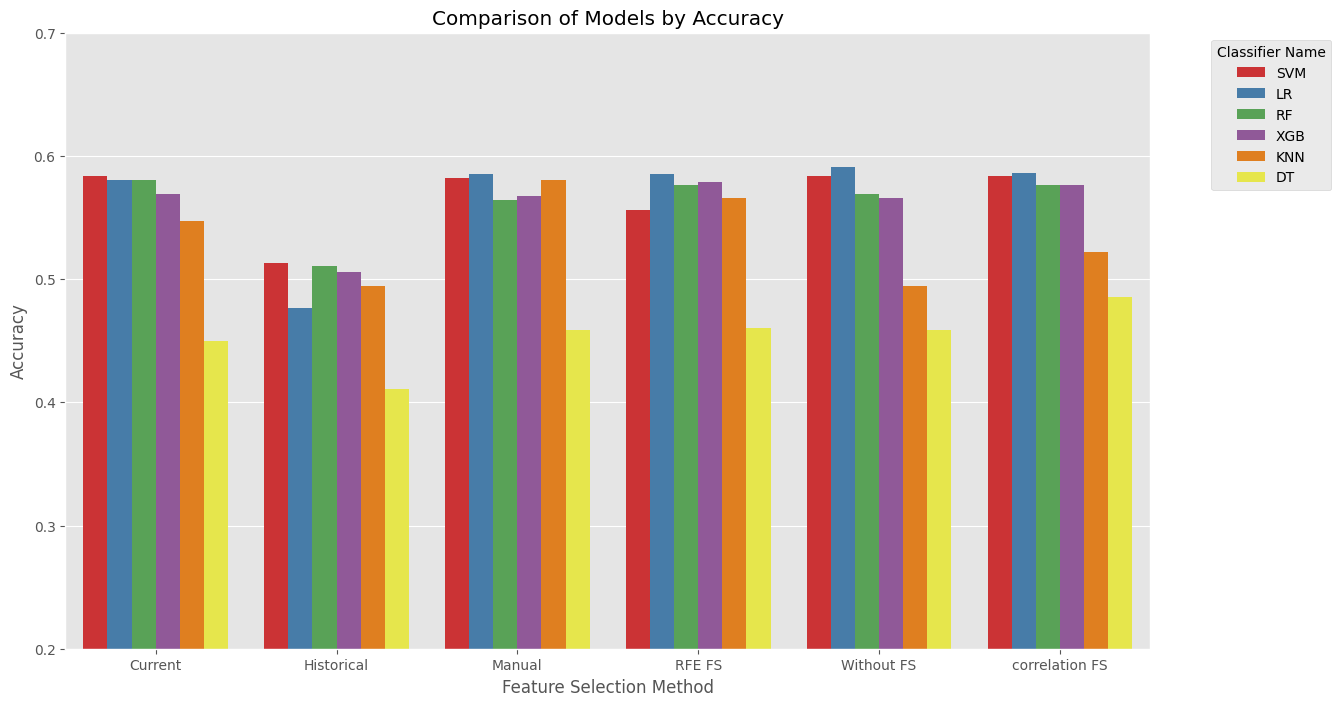

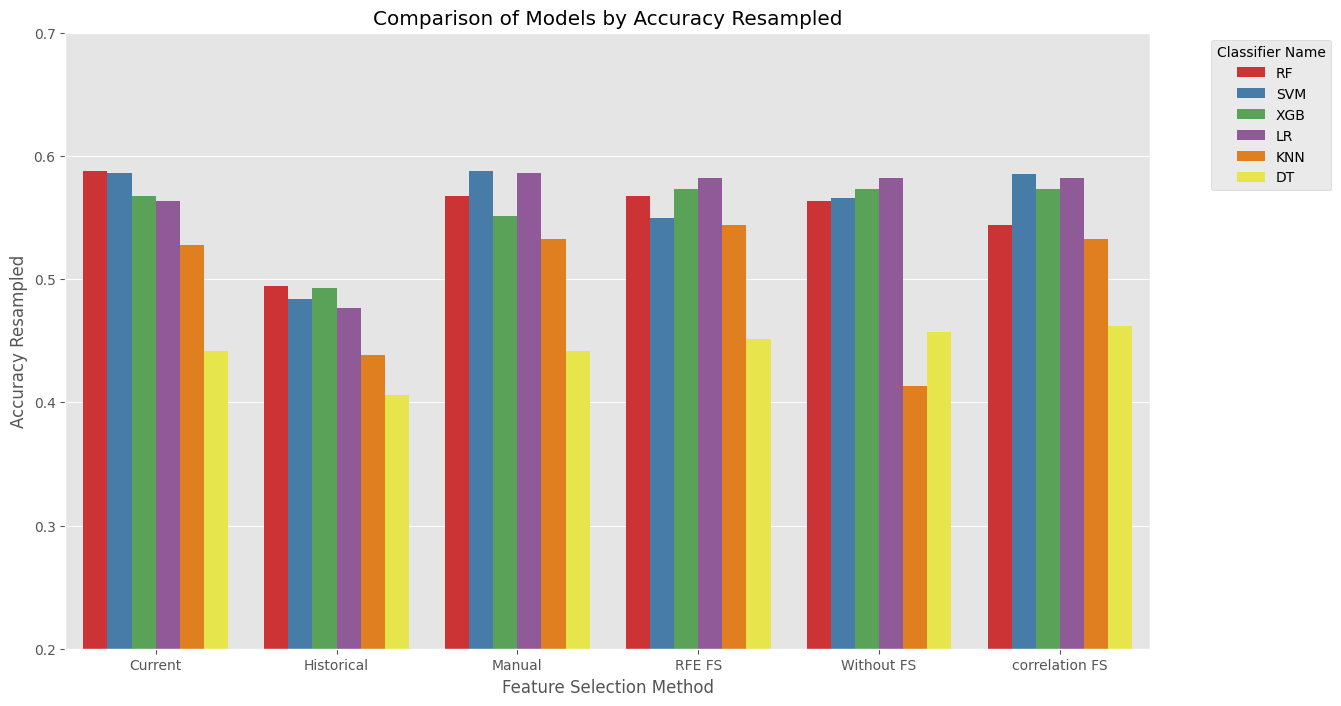

In [250]:
def sort_data(group, column_name):
    return group.sort_values(by=column_name,  ascending=False)

result_df = result_df.reset_index()
# Sort the data by 'Accuracy'
sorted_by_acc = result_df.groupby('Feature Selection', group_keys=False).apply(sort_data, column_name='Accuracy')
# Sort the data by 'Accuracy Resampled'
sorted_by_accRes = result_df.groupby('Feature Selection', group_keys=False).apply(sort_data, column_name='Accuracy Resampled')

# Plotting Accuracy
plt.figure(figsize=(14, 8))
sns.barplot(x='Feature Selection', y='Accuracy', hue='Classifier Name', data=sorted_by_acc, capsize=0.8, dodge=True, palette='Set1')

plt.title('Comparison of Models by Accuracy')
plt.xlabel('Feature Selection Method')
plt.ylabel('Accuracy')
plt.ylim(0.2,0.7)  # Customize the y-axis limits
plt.legend(title='Classifier Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting Accuracy Resampled
plt.figure(figsize=(14, 8))
sns.barplot(x='Feature Selection', y='Accuracy Resampled', hue='Classifier Name', data=sorted_by_accRes, capsize=0.8, dodge=True, palette='Set1')

plt.title('Comparison of Models by Accuracy Resampled')
plt.xlabel('Feature Selection Method')
plt.ylabel('Accuracy Resampled')
plt.ylim(0.2, 0.7)  # Customize the y-axis limits
plt.legend(title='Classifier Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




## LSTM (Time Series)

In [116]:
df.columns

Index(['Game ID', 'Wk', 'Day', 'Date', 'Time', 'Home', 'xG Home', 'G Home',
       'Away', 'xG Away', 'G Away', 'Score', 'Home Avg Players Score',
       'Away Avg Players Score', 'Home Points', 'Away Points', 'xScore',
       'Home Avg Points', 'Away Avg Points', 'Home Avg Goals For',
       'Away Avg Goals For', 'Home Avg Goals Against',
       'Away Avg Goals Against', 'Home Matches Played', 'Away Matches Played',
       'Home Points/Match', 'Away Points/Match', 'Home Form Points',
       'Away Form Points', 'Home Form Goals For', 'Away Form Goals For',
       'Home Form Goals Against', 'Away Form Goals Against',
       'Home Head-to-Head Points', 'Away Head-to-Head Points',
       'Home Head-to-Head Goals For', 'Away Head-to-Head Goals For',
       'Home Head-to-Head Goals Against', 'Away Head-to-Head Goals Against',
       'Season'],
      dtype='object')

In [76]:
df

Game ID  Wk  Day       Date   Time            Home  xG Home  G Home  \
0           0   1  Fri 2019-08-09  20:00       Liverpool      1.8       4   
1           1   1  Sat 2019-08-10  12:30        West Ham      1.1       0   
2           2   1  Sat 2019-08-10  15:00         Burnley      0.9       3   
3           3   1  Sat 2019-08-10  15:00         Watford      0.7       0   
4           4   1  Sat 2019-08-10  15:00  Crystal Palace      0.9       0   
...       ...  ..  ...        ...    ...             ...      ...     ...   
1895      418  38  Sun 2024-05-19  16:00       Brentford      1.1       2   
1896      419  38  Sun 2024-05-19  16:00         Chelsea      1.1       2   
1897      420  38  Sun 2024-05-19  16:00  Crystal Palace      2.5       5   
1898      421  38  Sun 2024-05-19  16:00       Liverpool      4.5       2   
1899      422  38  Sun 2024-05-19  16:00         Burnley      1.2       1   

                 Away  xG Away  ...  Away Form Goals For  \
0        Norwich City      0.9  ...                  0.0   
1     Manchester City      3.2  ...                  0.0   
2         Southampton      1.2  ...                  0.0   
3            Brighton      0.8  ...                  0.0   
4             Everton      1.1  ...                  0.0   
...               ...      ...  ...                  ...   
1895    Newcastle Utd      3.4  ...                  2.4   
1896      Bournemouth      2.2  ...                  1.2   
1897      Aston Villa      0.9  ...                  2.0   
1898           Wolves      0.5  ...                  0.8   
1899  Nott'ham Forest      1.7  ...                  1.4   

      Home Form Goals Against  Away Form Goals Against  \
0                         0.0                      0.0   
1                         0.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      0.0   
4                         0.0                      0.0   
...                       ...                      ...   
1895                      0.6                      1.6   
1896                      1.0                      1.6   
1897                      0.8                      1.4   
1898                      2.0                      2.4   
1899                      1.8                      2.0   

      Home Head-to-Head Points  Away Head-to-Head Points  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1895                       0.2                       2.6   
1896                       1.6                       1.0   
1897                       0.8                       2.0   
1898                       2.4                       0.6   
1899                       1.0                       1.0   

      Home Head-to-Head Goals For  Away Head-to-Head Goals For  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          0.0   
3                             0.0                          0.0   
4                             0.0                          0.0   
...                           ...                          ...   
1895                          1.0                          2.6   
1896                          1.4                          0.8   
1897                          1.2                          1.6   
1898                          1.8                          1.0   
1899                          1.0                          1.0   

      Home Head-to-Head Goals Against  Away Head-to-Head Goals Against  Season  
0                                 0.0                              0

In [109]:
lstm_df = df.copy()

lstm_df = lstm_df.drop(['id', 'Wk', 'Day','Time','Home Points', 'Away Points'], axis =1)
lstm_df['Date'] = pd.to_datetime(lstm_df['Date'],dayfirst=True)

In [118]:
home_features.remove('Home')
home_features

['xG Home',
 'G Home',
 'Home Avg Points',
 'Home Avg Goals For',
 'Home Avg Goals Against',
 'Home Matches Played',
 'Home Points/Match',
 'Home Form Points',
 'Home Form Goals For',
 'Home Form Goals Against',
 'Home Head-to-Head Points',
 'Home Head-to-Head Goals For',
 'Home Head-to-Head Goals Against',
 'Home Avg Players Score',
 'Home Star Player Count']

In [251]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization , Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


# Assuming df contains your dataset with game data for multiple teams
sequence_length = 10

X, y =  [], []




home_features = [c  for c in lstm_df.columns if 'Home' in c]
away_features =  [c  for c in lstm_df.columns if 'Away' in c]

home_features.remove('Home')
away_features.remove('Away')
teams = lstm_df['Home'].unique()  # Get unique team names

for team in teams:
    team_games = lstm_df[(lstm_df['Home'] == team) | (lstm_df['Away'] == team)].sort_values(by='Date') # Get games for the current team
    for i in range(len(team_games) - sequence_length):
        sequence_data = []
        for j in range(sequence_length):
            game = team_games.iloc[i+j]
            score = game['Score']
            if game['Home'] == team:
                features = game[home_features].values
            else:
                score = -game['Score']
                features = game[away_features].values
            
            # Append the modified score to the feature set
            features_with_score = np.append(features, score)
            sequence_data.append(features_with_score)
        X.append(sequence_data)
        
        # Adjust the score depend if the current team is home or away 
        target_game = team_games.iloc[i+sequence_length]
        score = target_game['Score']
        if team == target_game['Away']:
            score = -score
        y.append(score)


In [252]:
print(y[0])
X[0]

1


[array([1.8, 4, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 87.77,
        9, 1], dtype=object),
 array([1.3, 2, 3.0, 4.0, 1.0, 1, 3.0, 3.0, 4.0, 1.0, 0.0, 0.0, 0.0, 87.08,
        8, 1], dtype=object),
 array([2.5, 3, 3.0, 3.0, 1.0, 2, 3.0, 3.0, 3.0, 1.0, 0.0, 0.0, 0.0, 87.08,
        8, 1], dtype=object),
 array([1.0, 3, 3.0, 3.0, 1.0, 3, 3.0, 3.0, 3.0, 1.0, 0.0, 0.0, 0.0, 87.08,
        8, 1], dtype=object),
 array([3.0, 3, 3.0, 3.0, 0.75, 4, 3.0, 3.0, 3.0, 0.75, 0.0, 0.0, 0.0,
        87.16, 7, 1], dtype=object),
 array([0.6, 2, 3.0, 3.0, 0.8, 5, 3.0, 3.0, 3.0, 0.8, 0.0, 0.0, 0.0, 87.11,
        8, 1], dtype=object),
 array([1.9, 1, 3.0, 2.83, 0.83, 6, 3.0, 3.0, 2.6, 0.8, 0.0, 0.0, 0.0,
        87.08, 8, 1], dtype=object),
 array([3.5, 2, 3.0, 2.57, 0.71, 7, 3.0, 3.0, 2.4, 0.6, 0.0, 0.0, 0.0,
        87.21, 8, 1], dtype=object),
 array([1.2, 1, 3.0, 2.5, 0.75, 8, 3.0, 3.0, 2.2, 0.6, 0.0, 0.0, 0.0, 87.1,
        8, 0], dtype=object),
 array([2.6, 2, 2.78, 2.33, 0.78, 9, 2.7

In [254]:
X = np.array(X,dtype=np.float32)
y = np.array(y,dtype=np.float32)
label_mapping = {-1: 0, 0: 1, 1: 2}

# Map the labels to score will be beteen 0 to 2
y_mapped = np.array([label_mapping[label] for label in y])

# Reshape X to match LSTM input shape (samples, time steps, features)
X = np.reshape(X, (X.shape[0], sequence_length, len(X[0][0])))
split = int(0.8 * len(X))  # 80% training, 20% testing
X_train_lstm, X_test_lstm = X[:split], X[split:]
y_train_lstm, y_test_lstm = y_mapped[:split], y_mapped[split:]


In [255]:
X.shape

(12568, 10, 16)

### Apply LSTM on the  dataset

#### balance the lstm dataset

In [256]:
class_weights = {
    0: (y_train_lstm == 0).sum(),  # Weight for draws
    1: (y_train_lstm == 1).sum(),  # Weight for wins
    2: (y_train_lstm == 2).sum()   # Weight for losses
}
class_weights

{0: 3681, 1: 2530, 2: 3843}

In [258]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=25, kernel_regularizer=l2(0.01)))
model.add(Dense(25, activation='relu'))
model.add(Dense(3, activation='softmax'))  



learning_rate = 0.001 
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights = True)  # Stop training if validation loss doesn't improve for 5 epochs

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 100)           46800     
                                                                 
 dropout_12 (Dropout)        (None, 10, 100)           0         
                                                                 
 batch_normalization_12 (Ba  (None, 10, 100)           400       
 tchNormalization)                                               
                                                                 
 lstm_19 (LSTM)              (None, 10, 50)            30200     
                                                                 
 dropout_13 (Dropout)        (None, 10, 50)            0         
                                                                 
 batch_normalization_13 (Ba  (None, 10, 50)            200       
 tchNormalization)                                    

In [260]:
history = model.fit(
    X_train_lstm, 
    y_train_lstm, 
    epochs=100, 
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stopping]
)
# Evaluation
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print("Test Accuracy:", accuracy)
print("Test loss:", loss)


Epoch 1/100
315/315 [==============================] - 15s 49ms/step - loss: 1.0504 - accuracy: 0.4753 - val_loss: 1.0694 - val_accuracy: 0.4407
Epoch 2/100
315/315 [==============================] - 15s 47ms/step - loss: 1.0508 - accuracy: 0.4775 - val_loss: 1.0738 - val_accuracy: 0.4308
Epoch 3/100
315/315 [==============================] - 15s 49ms/step - loss: 1.0501 - accuracy: 0.4807 - val_loss: 1.0727 - val_accuracy: 0.4240
Epoch 4/100
315/315 [==============================] - 15s 48ms/step - loss: 1.0485 - accuracy: 0.4755 - val_loss: 1.0588 - val_accuracy: 0.4650
Epoch 5/100
315/315 [==============================] - 15s 47ms/step - loss: 1.0491 - accuracy: 0.4767 - val_loss: 1.0696 - val_accuracy: 0.4304
Epoch 6/100
315/315 [==============================] - 14s 44ms/step - loss: 1.0481 - accuracy: 0.4762 - val_loss: 1.0693 - val_accuracy: 0.4535
Epoch 7/100
315/315 [==============================] - 12s 38ms/step - loss: 1.0503 - accuracy: 0.4757 - val_loss: 1.0725 - val_ac

79/79 [==============================] - 2s 11ms/step


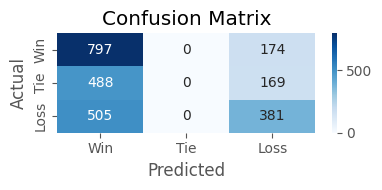

array([[0.47234398, 0.27894464, 0.24871142],
       [0.47067395, 0.27891883, 0.25040725],
       [0.47102338, 0.27892217, 0.25005445],
       ...,
       [0.500189  , 0.27907452, 0.22073649],
       [0.49896824, 0.27907488, 0.22195688],
       [0.49658313, 0.27907178, 0.22434504]], dtype=float32)

In [261]:
pred = model.predict(X_test_lstm)
pred_class =np.argmax(pred, axis=1)
plot_confusion_matrix(y_test=y_test_lstm, y_pred= pred_class)
pred

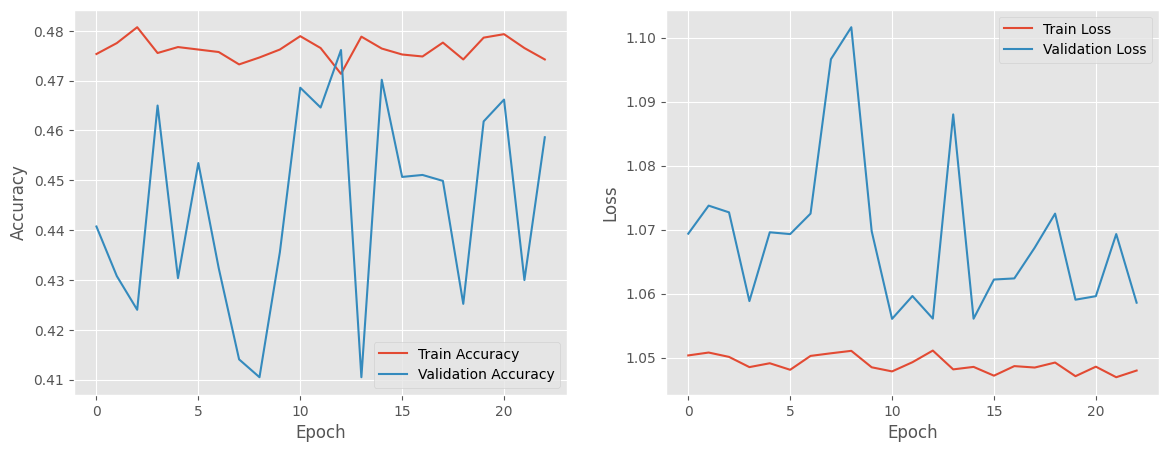

In [262]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Lstm on resample data set

In [257]:
from imblearn.over_sampling import SMOTE
X_train_reshaped = X_train_lstm.reshape(X_train_lstm.shape[0], -1)

smote = SMOTE(sampling_strategy='auto', random_state=42)  # Resample to balance class distribution
X_lstm_resampled, y_lstm_resampled = smote.fit_resample(X_train_reshaped, y_train_lstm)

X_lstm_resampled = X_lstm_resampled.reshape(-1, X_train_lstm.shape[1], X_train_lstm.shape[2])
class_weights_resampled = {
    0: (y_lstm_resampled == 0).sum(),  # Weight for draws
    1: (y_lstm_resampled == 1).sum(),  # Weight for wins
    2: (y_lstm_resampled == 2).sum()   # Weight for losses
}
class_weights_resampled

{0: 3843, 1: 3843, 2: 3843}

In [294]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=25, kernel_regularizer=l2(0.01)))
model.add(Dense(25, activation='relu'))
model.add(Dense(3, activation='softmax'))  



learning_rate = 0.0005 
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights = True)  # Stop training if validation loss doesn't improve for 5 epochs

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 10, 100)           46800     
                                                                 
 dropout_18 (Dropout)        (None, 10, 100)           0         
                                                                 
 batch_normalization_18 (Ba  (None, 10, 100)           400       
 tchNormalization)                                               
                                                                 
 lstm_28 (LSTM)              (None, 10, 50)            30200     
                                                                 
 dropout_19 (Dropout)        (None, 10, 50)            0         
                                                                 
 batch_normalization_19 (Ba  (None, 10, 50)            200       
 tchNormalization)                                    

In [295]:
history = model.fit(
    X_lstm_resampled, 
    y_lstm_resampled, 
    epochs=100, 
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stopping]
)
# Evaluation
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print("Test Accuracy:", accuracy)
print("Test loss:", loss)


Epoch 1/100
361/361 [==============================] - 31s 48ms/step - loss: 2.0047 - accuracy: 0.3831 - val_loss: 1.4065 - val_accuracy: 0.3998
Epoch 2/100
361/361 [==============================] - 15s 42ms/step - loss: 1.2608 - accuracy: 0.4142 - val_loss: 1.1891 - val_accuracy: 0.4177
Epoch 3/100
361/361 [==============================] - 15s 43ms/step - loss: 1.1481 - accuracy: 0.4204 - val_loss: 1.1431 - val_accuracy: 0.4212
Epoch 4/100
361/361 [==============================] - 15s 43ms/step - loss: 1.1079 - accuracy: 0.4166 - val_loss: 1.1312 - val_accuracy: 0.4093
Epoch 5/100
361/361 [==============================] - 15s 41ms/step - loss: 1.0908 - accuracy: 0.4171 - val_loss: 1.1056 - val_accuracy: 0.4308
Epoch 6/100
361/361 [==============================] - 15s 41ms/step - loss: 1.0823 - accuracy: 0.4182 - val_loss: 1.1171 - val_accuracy: 0.3807
Epoch 7/100
361/361 [==============================] - 15s 42ms/step - loss: 1.0751 - accuracy: 0.4281 - val_loss: 1.0981 - val_ac

79/79 [==============================] - 2s 12ms/step


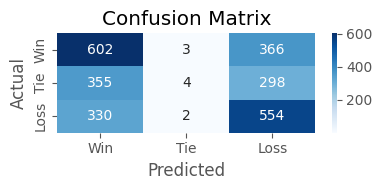

array([[0.43748295, 0.35421932, 0.20829777],
       [0.4273956 , 0.35479727, 0.21780714],
       [0.4160683 , 0.35463777, 0.22929393],
       ...,
       [0.4333452 , 0.35365513, 0.21299961],
       [0.4469338 , 0.35239843, 0.2006677 ],
       [0.44591436, 0.35248706, 0.20159855]], dtype=float32)

In [296]:
pred = model.predict(X_test_lstm)
pred_class =np.argmax(pred, axis=1)
plot_confusion_matrix(y_test=y_test_lstm, y_pred= pred_class)
pred

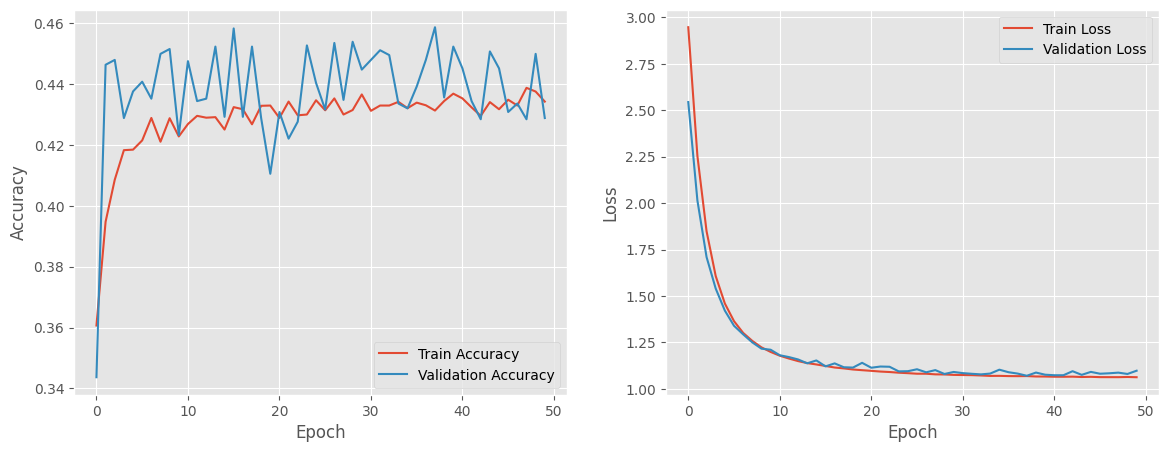

In [271]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Feature importance

In [285]:
# Initialize empty lists to accumulate feature importance scores
importance = np.zeros(len(withoutFS.getSelectedFeatureIindices()))
divideBy = np.zeros(len(withoutFS.getSelectedFeatureIindices()))
# Loop through all feature selection methods
for Fs in allFS:
    currImportance = np.zeros(len(Fs.getSelectedFeatureIindices()))
    # Logistic Regression
    for estimator in Fs.LR.model.estimators_:
        currImportance += np.abs(estimator.coef_[0])

    # Decision Tree
    currImportance += list(Fs.DT.model.feature_importances_)

    # Random Forest
    currImportance += list(Fs.RF.model.feature_importances_)

    # AdaBoost
    currImportance += list(Fs.XGB.model.feature_importances_)
    importance[Fs.getSelectedFeatureIindices()]+= currImportance
    # addaing to divideBy what inidices we used, so we can calculate aggreatation.
    divideBy[Fs.getSelectedFeatureIindices()] += 4

# Aggregate feature importance scores
aggregated_importance = importance/divideBy

feature_ranking = np.argsort(aggregated_importance)[::-1]

In [291]:
# Print the ranking of features
# To see clearly the proportions we multiply by 100 the scores
print("\tScore avarge and aggreation sort by ranking \n")
for rank, feature_idx in enumerate(feature_ranking):
    print(f"Rank {rank + 1:2}: Feature Name: {encoded_features.columns[feature_idx].ljust(33)} Importance Score: {aggregated_importance[feature_idx]:.6f}")

	Score avarge and aggreation sort by ranking 

Rank  1: Feature Name: xG Home                           Importance Score: 3.132608
Rank  2: Feature Name: xG Away                           Importance Score: 2.364281
Rank  3: Feature Name: Home Avg Players Score            Importance Score: 1.347651
Rank  4: Feature Name: Away Avg Players Score            Importance Score: 0.990981
Rank  5: Feature Name: Home Avg Goals For                Importance Score: 0.677357
Rank  6: Feature Name: Home Avg Goals Against            Importance Score: 0.582610
Rank  7: Feature Name: xScore                            Importance Score: 0.527338
Rank  8: Feature Name: Away Avg Points                   Importance Score: 0.523291
Rank  9: Feature Name: Away Avg Goals Against            Importance Score: 0.480880
Rank 10: Feature Name: Away Avg Goals For                Importance Score: 0.416203
Rank 11: Feature Name: Home Avg Points                   Importance Score: 0.402707
Rank 12: Feature Name: Home P

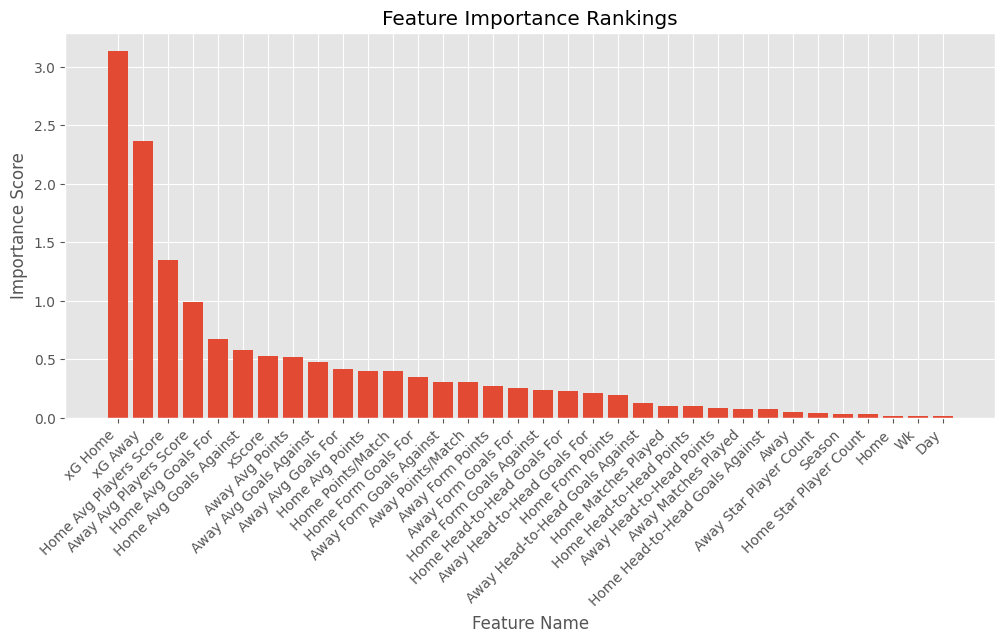

In [293]:
# Create a figure and axis for the plot
plt.figure(figsize=(12, 5))
ax = plt.gca()

# Plot the importance scores
ax.bar(range(X_train.shape[1]), aggregated_importance[feature_ranking])
plt.xticks(range(X_train.shape[1]), [encoded_features.columns[i] for i in feature_ranking], rotation=45, ha='right')

ax.set_xlabel('Feature Name')
ax.set_ylabel('Importance Score')
plt.title('Feature Importance Rankings')

plt.show()
